**Импорт библиотек**

In [1]:
pip install -U scikit-learn phik shap -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from IPython.display import display

# модули для работы с моделями:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier, DummyRegressor

# Кодировщики, масштабировние
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

# Модели
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

# Метрики
from sklearn.metrics import make_scorer, roc_auc_score, RocCurveDisplay, f1_score


import phik
import shap

**Константы**

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## **Часть 1**

Предсказание уровня удовлетворенности.

### **Загрузка данных**

In [4]:
# Функция для отображения части датасета и информации о нем

def show_info(df):
    display(df.head())
    df.info()

**Загрузим данные**

In [5]:
X_train_sat = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
X_test_sat = pd.read_csv('C:/test_features.csv')
y_test_sat = pd.read_csv('C:/test_target_job_satisfaction_rate.csv')

#### X_train_sat

In [6]:
show_info(X_train_sat)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


* 4000 строк
* 10 колонок, включая id

Типы данных, количество столбцов:  
1. object, 5 столбцов
  * `dept`, `level`, `workload`, `last_year_promo`, `last_year_violations`
2. int, 4 столбца
  * `id`, `employment_years`, `supervisor_evaluation`, `salary`
3. float, 1 столбец
  * `job_satisfaction_rate`

Видно 2 столбца, в которых имеются пропуски:
* `dept`, `level`

Типы данных корректны.   

Наименования столбцов корректные, стилистика соблюдается.

Целевой признак - `job_satisfaction_rate`



#### X_test_sat

In [7]:
show_info(X_test_sat)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


2000 строк, 9 столбцов.

Датасет по количеству строк в два раза меньше тренировочного.  
Столбцов - такое же количество минус целевой признак.

Типы данных, количество столбцов:  
1. object, 5 столбцов
  * `dept`, `level`, `workload`, `last_year_promo`, `last_year_violations`
2. int, 4 столбца
  * `id`, `employment_years`, `supervisor_evaluation`, `salary`

Незаполненные значения в столбцах:
`dept`, `level`

Типы данных корректны.   

Наименования столбцов корректные, стилистика соблюдается.

#### y_test_sat

In [8]:
show_info(y_test_sat)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


2000 строк, 2 столбца

Количество строк совпадает с X_test_sat.

- `id` - int  
- `job_satisfaction_rate` (таргет) - float

Типы и названия столбцов корректны.  
Пропусков не видно.

#### **Вывод по 1 разделу**

Загружены и изучены данные из 3 датасетов:
1. Тренировочная выборка 4000 строк, 8 столбцов с признаками + столбцы `id` и таргет `job_satisfaction_rate`
2. Тестовая выборка без таргета, 2000 строк, 7 столбцов с признаками + `id`
3. Значения целевых признаков для тестовой выборки таргет, 2000 строк, 2 столбца: `job_satisfaction_rate` + `id`

Типы и названия столбцов корректны, вносить изменения не требуется.

Есть пропущенные значения. Нужно будет их изучить и обработать на следующем этапе.

### **Предобработка данных**

**Функции, которые будем использовать:**

In [9]:
# 1. Для поиска и просмотра явных дубликатов:
def duplicates_find(df):
    
    # Если дубликаты есть:    
    if df.duplicated().sum()>0:
        # Количество явных дубликатов
        print ('Количество явных дубликатов:', df.duplicated().sum())
        # Выводим на экран дубликаты
        display(df.loc[df.duplicated()])
    # Если дубликатов нет:
    else:
        print ('Явных дубликатов не найдено')
        
# 2. Для просмотра уникальных значений объектов типа Object: 
def uniques(df):
    for column in df.columns:
        if df[column].dtype == 'O':
            print (f'{column}: \n {df[column].unique()} \n ')

# 3. Пайплайн для заполнения пропусков
imp_pipe = Pipeline(
    [
        ('SimpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))        
    ]
)

#### X_train_sat

**Пропуски:**

In [10]:
X_train_sat.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

* суммарно 10 пропусков в столбцах `dept` и `level`

Посмотрим, стоит ли удалить эти строки или заменить на среднее значение по группе/моду и т.д.

Чтобы оценить критичность ошибки в этих столбцах, посмотрим, насколько наш целевой признак чувствителен к значениям в них:

In [11]:
# В interval_cols добавляем названия непрерывных признаков - содержащие неогранич. число вариантов
interval_cols = ['salary', 'job_satisfaction_rate']

X_train_sat[['job_satisfaction_rate', 'dept', 'level']].phik_matrix(interval_cols=interval_cols)

,job_satisfaction_rate,dept,level
job_satisfaction_rate,1.000000,0.082086,0.08062
dept,0.082086,1.000000,0.00000
level,0.080620,0.000000,1.00000


* Корреляция слабая. Можно производить замену.

Ознакомимся с пропусками:

In [12]:
X_train_sat.loc[(X_train_sat['dept'].isna()) | (X_train_sat['level'].isna())].sort_values(by='dept')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


**Для `level`:** 
- уровень зарплат от 18000 до 27600 тысяч
- год - длительность работы для всех работников

Посмотрим, как распределены зарплаты и длительность работы для работников разных должностей:

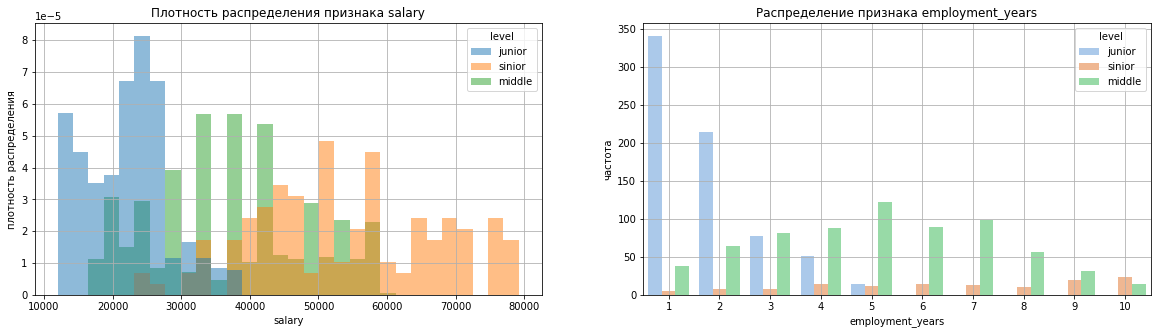

In [13]:
f, ax = plt.subplots(1, 2)
f.set_size_inches(20, 5)
p=0
y_labels = ['плотность распределения', 'частота']
for i in ['salary', 'employment_years']:
    if i == 'salary':
        sns.histplot(data=X_train_sat.query('dept == "sales"'), x=i, bins=30, stat='density', common_norm=False, 
                     hue='level', color='coral', edgecolor=None, ax=ax[p])
        ax[p].set_title(f'Плотность распределения признака {i}')
    else:
        sns.countplot(data=X_train_sat.query('dept == "sales"'), x=i,  
                      hue='level', palette='pastel', edgecolor=None, ax=ax[p])
        ax[p].set_title(f'Распределение признака {i}')
    ax[p].grid()
    ax[p].set_xlabel(i)
    ax[p].set_ylabel(y_labels[p])
    p += 1

* Значения `salary` и `employment_years` в пропусках по `level` больше всего подходят под категорию "junior"

Заменим пропуски `level` на "junior" c помощью пайплайна:

Для `dept`:

По имеющимся признакам не можем корректно определить отдел, в котором работает сотрудник.  

Посмотрим, как часто встречаются в датасете разные отделы:

In [14]:
display(X_train_sat['dept'].value_counts(normalize=True).head(2))
X_train_sat['level'].value_counts(normalize=True).head(2)

sales         0.378568
technology    0.216825
Name: dept, dtype: float64

junior    0.473974
middle    0.436436
Name: level, dtype: float64

Как раз наиболее популярный - junior и sales.  
Пропущенные значения в `dept` и `level` заменим с помощью пайплайна:

In [15]:
X_train_sat[['dept', 'level']] = imp_pipe.fit_transform(X_train_sat[['dept', 'level']])

# Проверяем, что пропусков не осталось
X_train_sat.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

**Явные дубликаты:**

In [16]:
duplicates_find(X_train_sat)

Явных дубликатов не найдено


**Неявные дубликаты:**

In [17]:
uniques(X_train_sat)

dept: 
 ['sales' 'hr' 'technology' 'purchasing' 'marketing'] 
 
level: 
 ['junior' 'middle' 'sinior'] 
 
workload: 
 ['medium' 'high' 'low'] 
 
last_year_promo: 
 ['no' 'yes'] 
 
last_year_violations: 
 ['no' 'yes'] 
 


* Дубликатов нет

Тем не менее, исправим опечатку - 'sinior' на 'senior':

In [18]:
X_train_sat['level'] = X_train_sat['level'].replace('sinior', 'senior')
X_train_sat['level'].unique()

array(['junior', 'middle', 'senior'], dtype=object)

#### X_test_sat

**Пропуски:**

In [19]:
X_test_sat.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Ознакомимся с пропусками:

In [20]:
X_test_sat.loc[(X_test_sat['dept'].isna()) | (X_test_sat['level'].isna())].sort_values(by='dept')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
312,471990,sales,NaN,low,1,no,no,3,12000
191,609865,NaN,junior,medium,1,no,no,1,20400
1196,832342,NaN,junior,medium,1,no,no,4,28800


Пропуск в level похож на пропуски в датасете X_train_sat:
  * подразделение sales, 1 год работы и низкая зарплата
  
Заменим пропуски так же, как и в 1.2.1:

In [21]:
X_test_sat[['dept', 'level']] = imp_pipe.transform(X_test_sat[['dept', 'level']])

# Проверяем, что пропусков не осталось
X_test_sat.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

**Явные дубликаты:**

In [22]:
duplicates_find(X_test_sat)

Явных дубликатов не найдено


**Неявные дубликаты:**

In [23]:
uniques(X_test_sat)

dept: 
 ['marketing' 'hr' 'sales' 'purchasing' 'technology' ' '] 
 
level: 
 ['junior' 'middle' 'sinior'] 
 
workload: 
 ['medium' 'low' 'high' ' '] 
 
last_year_promo: 
 ['no' 'yes'] 
 
last_year_violations: 
 ['no' 'yes'] 
 


* есть пустые значения в `dept` и `workload`
* опечатка "sinior"

Исправляем опечатку "sinior":

In [24]:
X_test_sat['level'] = X_test_sat['level'].replace('sinior', 'senior')
X_test_sat['level'].unique()

array(['junior', 'middle', 'senior'], dtype=object)

Посмотрим на пропущенные значения:

In [25]:
X_test_sat.query('dept == " " or workload == " "')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800
1699,822186,,middle,medium,3,no,no,4,38400


Пропуск заменим на самые популярные значения:

In [26]:
# Замена
X_test_sat['workload'] = X_test_sat['workload'].replace(' ', np.nan)
X_test_sat['dept'] = X_test_sat['dept'].replace(' ', np.nan)
X_test_sat[['dept', 'workload']] = imp_pipe.fit_transform(X_test_sat[['dept', 'workload']])

# Проверка
uniques(X_test_sat)

dept: 
 ['marketing' 'hr' 'sales' 'purchasing' 'technology'] 
 
level: 
 ['junior' 'middle' 'senior'] 
 
workload: 
 ['medium' 'low' 'high'] 
 
last_year_promo: 
 ['no' 'yes'] 
 
last_year_violations: 
 ['no' 'yes'] 
 


#### y_test_sat

**Пропуски:**

In [27]:
y_test_sat.isna().sum()

id                       0
job_satisfaction_rate    0
dtype: int64

* отсутствуют

**Явные дубликаты:**

In [28]:
duplicates_find(y_test_sat)

Явных дубликатов не найдено


**Неявные дубликаты:**

Проверим, все ли значения `job_satisfaction_rate` входят в промежуток [0, 1]

In [29]:
y_test_sat.query('job_satisfaction_rate > 1 or job_satisfaction_rate < 0')

,id,job_satisfaction_rate


* Нет значений за пределами этого промежутка

#### Проверка корректности выборок по id

Перед дальнейшей работой необходимо убедиться, что:
* `id` в X_test_sat и y_test_sat полностью совпадают
* `id` X_train_sat не пересекаются с `id` других выборок

In [30]:
# Для удобства сохраним списки id выборок train и test в виде списка
test_id_list = X_test_sat['id'].unique().tolist()
train_id_list = X_train_sat['id'].unique().tolist()

In [31]:
print ('Процент повторяющихся id в X_test_sat и y_test_sat: \n', 
       (len(y_test_sat.query('id in @test_id_list')) / len(X_test_sat))*100)

print ('\nПроцент пересекающихся id в X_train_sat и y_test_sat: \n', 
       (len(y_test_sat.query('id in @train_id_list')) / len(X_train_sat))*100)

Процент повторяющихся id в X_test_sat и y_test_sat: 
 100.0

Процент пересекающихся id в X_train_sat и y_test_sat: 
 0.0


Выборки сформированы корректно, можно продолжать работу.

#### **Вывод по 2 разделу**

В результате предобработки данных:

X_train_sat:
* Заполнены пропуски в столбцах `dept` и `level`
* Исправлена опечатка "sinior"

X_test_sat:
* Заполнены пропуски в столбцах `dept`, `level` и `workload`
* Исправлена опечатка "sinior"

y_test_sat:
* Убедились, что все значения `job_satisfaction_rate` входят в промежуток [0, 1]

Корректность выборок:
* Выборки сформированы корректно: 
  * списки `id` полностью совпадают у X_test_sat и y_test_sat и не пересекаются с X_train_sat

### **Исследовательский анализ данных**

Функции, которые будем использовать:

In [32]:
# 1. Для непрерывных величин - гистограмма и ящик с усами    
def make_hist(df, column, bins, hue, x_name):
    f, ax = plt.subplots(1, 2)
    f.set_size_inches(20, 5)
    plt.suptitle(column, fontweight='bold')
    # Гистограмма:
    sns.histplot(data=df, x=column, bins=bins, color='coral', hue=hue, edgecolor=None, ax=ax[0])
    ax[0].set_title('Распределение признака')
    ax[0].grid()
    ax[0].set_xlabel(x_name)
    ax[0].set_ylabel('частота')
    # Ящик с усами:
    ## vert=False, чтобы значения признака были по горизонтальной оси для обоих графиков
    sns.boxplot(data=df, x=column, y=hue, orient='h', color='cornflowerblue')
    ax[1].set_title('Ящик с усами')
    ax[1].grid()
    ax[1].set_xlabel(x_name)
    plt.show()

# 2
def make_hist_density(df, column, bins, hue, x_name):
    f, ax = plt.subplots(1, 2)
    f.set_size_inches(20, 5)
    plt.suptitle(column, fontweight='bold')
    # Гистограмма:
    sns.histplot(data=df, x=column, bins=bins, stat='density', common_norm=False, 
                 color='coral', hue=hue, edgecolor=None, ax=ax[0])
    ax[0].set_title('Распределение признака')
    ax[0].grid()
    ax[0].set_xlabel(x_name)
    ax[0].set_ylabel('Плотность распределения')
    # Ящик с усами:
    ## vert=False, чтобы значения признака были по горизонтальной оси для обоих графиков
    sns.boxplot(data=df, x=column, y=hue, orient='h', color='cornflowerblue')
    ax[1].set_title('Ящик с усами')
    ax[1].grid()
    ax[1].set_xlabel(x_name)
    plt.show()
    
# 3. Для дискретных величин с горизонтальным отображением
def make_countplot(df, y, ylabel):
    plt.figure(figsize=(10, 4))
    sns.countplot(y=y, data=df, palette='pastel')
    plt.title(y)
    plt.grid()
    plt.ylabel(ylabel)
    plt.xlabel('Частота')
    plt.show()    

# 4. Сравнение 2 дискретных величин с горизонтальным отображением
def compare_countplots(df, df2, y):
    plt.figure(figsize=(20, 6))
    p=1
    titles = ['X_train_sat', 'X_test_sat']
    for i in [df, df2]:
        plt.subplot(1, 2, p)
        plt.suptitle(f'Распределение признака: {y}', fontweight='bold')
        sns.countplot(y=y, data=i, palette='pastel')
        plt.title(titles_for_countplots[p-1])
        plt.xlabel('частота')
        plt.grid()
        p +=1
    plt.show()

# 5. Построение диаграммы
def build_pie(df, y):
    plt.pie(x=df.groupby(y)[y].count(), labels=df.groupby(y)[y].count().index,
            autopct='%1.1f%%', colors=sns.color_palette('pastel'))
    plt.title(f'Распределение признака: {y}', fontweight='bold')
    plt.show()

# 6. Построение 2 диаграмм
def compare_pie(df, df2, y):
    plt.figure(figsize=(10,5))
    p=1
    for i in [df, df2]:
        plt.subplot(1, 2, p)
        plt.suptitle(f'Распределение признака: {y}', fontweight='bold')
        plt.pie(x=i.groupby(y)[y].count(), labels=i.groupby(y)[y].count().index, 
                autopct='%1.1f%%', colors=sns.color_palette('pastel'))
        plt.title(titles_for_pie[p-1])
        p +=1
    plt.show()
    
# 7. Построение 3 диаграмм
def compare_pie_3(df, df2, df3, y):
    plt.figure(figsize=(15,5))
    p=1
    for i in [df, df2, df3]:
        plt.subplot(1, 3, p)
        plt.suptitle(f'Распределение признака: {y}', fontweight='bold')
        plt.pie(x=i.groupby(y)[y].count(), labels=i.groupby(y)[y].count().index, 
                autopct='%1.1f%%', colors=sns.color_palette('pastel'))
        plt.title(titles_for_pie[p-1])
        p +=1
    plt.show()

titles_for_countplots = ['X_train_sat', 'X_test_sat']
titles_for_pie = ['X_train_sat', 'X_test_sat']

# Для удобства создадим датафрейм, в котором объединим оба датасета
df_full = X_train_sat.merge(X_test_sat, how='outer')

Будем проводить исследовательский анализ одновременно по тренировочной и тестовой выборкам, чтобы оценить, есть ли различия.

#### dept 

Отделы

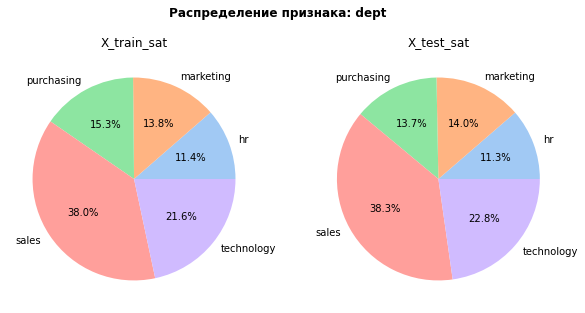

In [33]:
compare_pie(X_train_sat, X_test_sat, 'dept')

Примерно одинаковое соотношение выборок.

По убыванию численности представлены работники:
* 38% из отдела продаж - sales
* 22% из technology
* 13-15% из marketing и purchasing
* 11.3% hr - наименьшее количество

#### level 

Уровень занимаемой должности

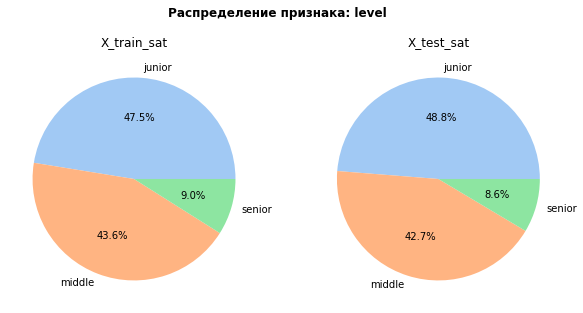

In [34]:
compare_pie(X_train_sat, X_test_sat, 'level')

Также одинаково представлены уровни занимаемых должностей.

Примерно одинаково middle и junior.  
Senior - всего  8.6 - 9%

#### workload 

Загруженность

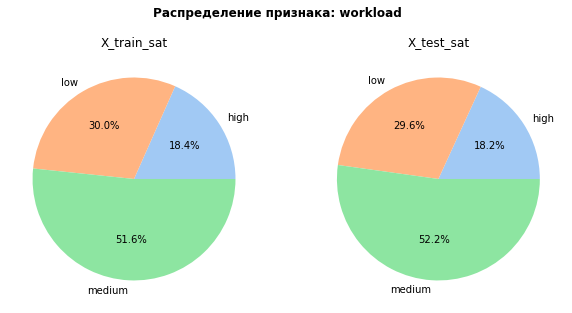

In [35]:
compare_pie(X_train_sat, X_test_sat, 'workload')

Данные разделены в датасетах в одинаковом соотношении.

* Половина работников имеют занятость уровня medium.
* Треть - low
* Менее 20% - high

#### employment_years

Длительность работы в компании (в годах)

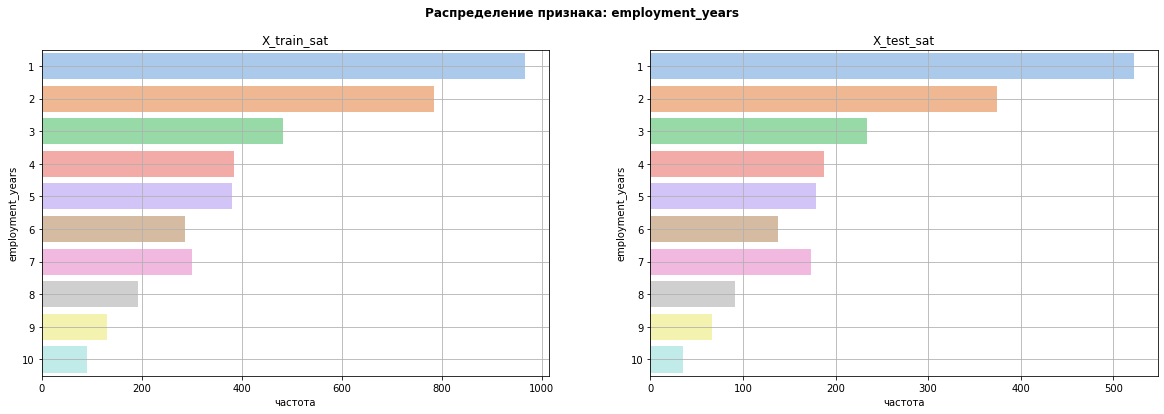

Доля сотрудников со стажем 1-2 года:  0.448
Доля сотрудников со стажем 5 лет и более:  0.252


In [36]:
compare_countplots(X_train_sat, X_test_sat, 'employment_years')
print ('Доля сотрудников со стажем 1-2 года: ', len(X_test_sat.query('employment_years < 3'))/len(X_test_sat))
print ('Доля сотрудников со стажем 5 лет и более: ', len(X_test_sat.query('employment_years > 5'))/len(X_test_sat))

Чаще всего в датасетах встречаются сотрудники со стажем работы в компании 1-2 года:
* 45%

С увеличение стажа работы доля сотрудников соответствующего стажа снижается.

Всего четверть сотрудников имеет стаж более 5 лет.

Посмотрим стажи в разбивке по уровню должности:


 Для сотрудников уровня junior:


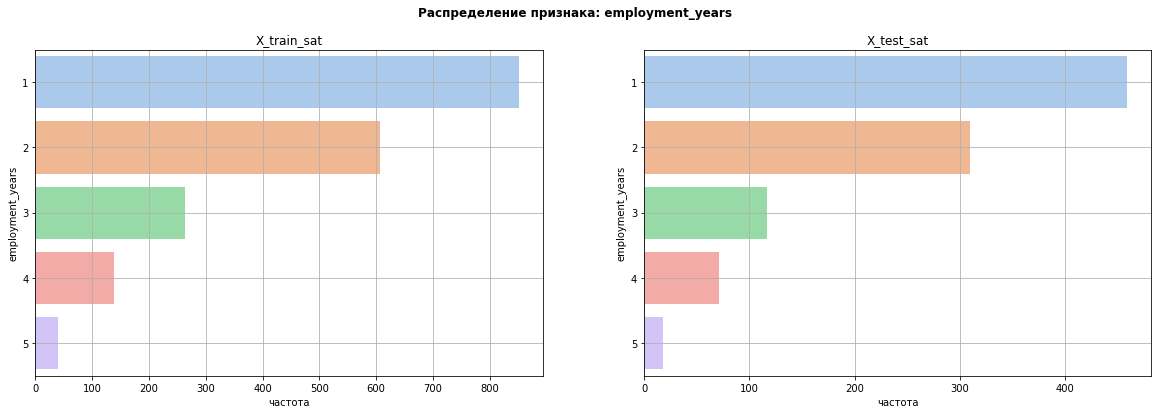

,count,mean,std,min,25%,50%,75%,max
employment_years,1898.0,1.898841,1.028476,1.0,1.0,2.0,2.0,5.0



 Для сотрудников уровня middle:


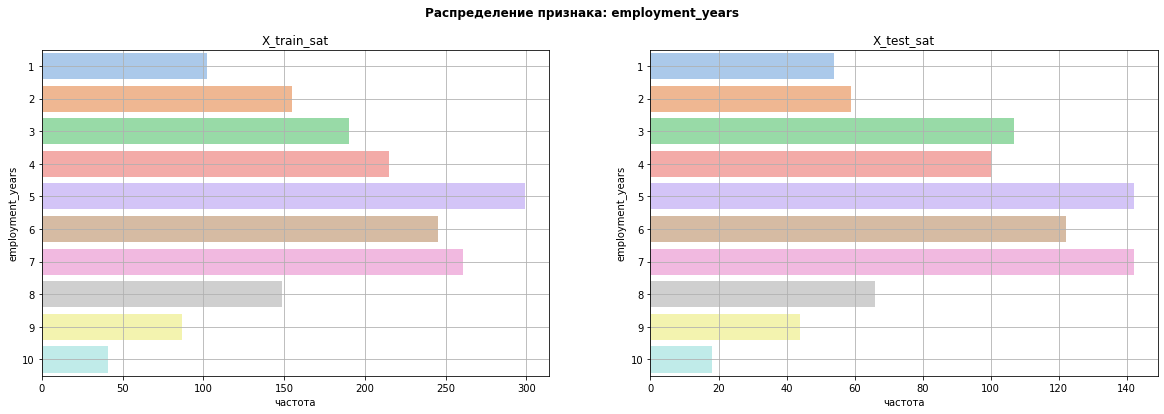

,count,mean,std,min,25%,50%,75%,max
employment_years,1744.0,5.171445,2.27205,1.0,3.0,5.0,7.0,10.0



 Для сотрудников уровня senior:


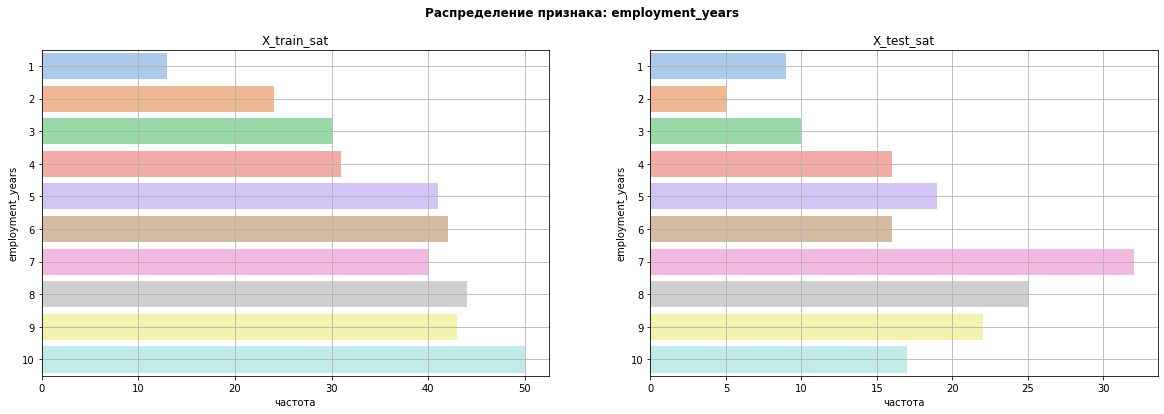

,count,mean,std,min,25%,50%,75%,max
employment_years,358.0,6.287709,2.655456,1.0,4.0,6.0,9.0,10.0


In [37]:
list_for_countplots = ['junior', 'middle', 'senior']
for i in list_for_countplots:
    print (f'\n Для сотрудников уровня {i}:')
    compare_countplots(X_train_sat.loc[X_train_sat['level']==i], 
                       X_test_sat.loc[X_test_sat['level']==i], 'employment_years')
    display(pd.DataFrame(X_train_sat.loc[X_train_sat['level']==i, 'employment_years'].describe()).T)

Junior:
* среднее - 1.9
* 75% работают 1-2 года
* Max - 5 лет

Middle:
* среднее - 5.17
* в 50% случаев работают от 3 до 7 лет
* min - 1 год, max - 10 лет

Senior:
* среднее - 6.29
* в 50% случаев работают от 4 до 9 лет
* min - 1 год, max - 10 лет

#### last_year_promo

Повышение за последний год

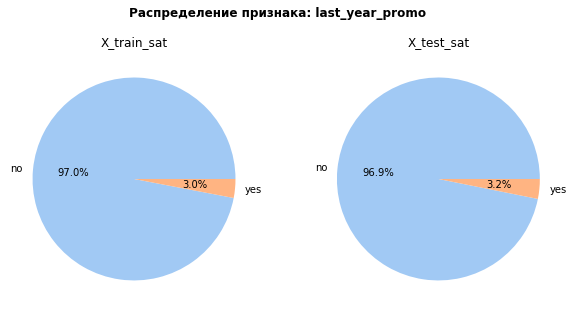

In [38]:
compare_pie(X_train_sat, X_test_sat, 'last_year_promo')

* Всего 3% сотрудников было повышено за последний год

Посмотрим, какие повышения происходили:

In [39]:
X_train_sat.query('last_year_promo == "yes"')['level'].value_counts()

middle    94
senior    26
Name: level, dtype: int64

* преимущественно были повышения до middle
* повышений до junior не было, что логично

Еще раз построим диаграммы без учета сотрудников уровня junior.  
Оценим процент повышенных сотрудников от общего количества специалистов middle и senior:

* без учета junior


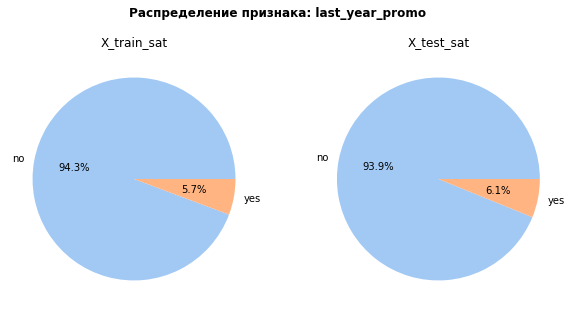

In [40]:
print ('* без учета junior')
compare_pie(X_train_sat.query('level != "junior"'), X_test_sat.query('level != "junior"'), 'last_year_promo')

* Среди всех действующих на момент составления датасета сотрудников уровня middle и junior около 6% были повышены за последний год.

Посмотрим на общее соотношение количества сотрудников уровней middle и senior:

In [41]:
X_train_sat.query('level != "junior"')['level'].value_counts()

middle    1744
senior     358
Name: level, dtype: int64

Посчитаем процент повышенных в последний год сотрудников среди middle и senior по всем данным:

In [42]:
# Считаем отношение повышенных сотрудников компании к общему количеству сотрудников уровня middle и senior
(X_train_sat.query('last_year_promo == "yes"')['level'].value_counts() / 
 X_train_sat.query('level != "junior"')['level'].value_counts())

middle    0.053899
senior    0.072626
Name: level, dtype: float64

* 5.4% сотрудников уровня middle повышены в последний год
* 7.3% сотрудников уровня senior повышены в последний год

#### last_year_violations

Нарушения за последний год

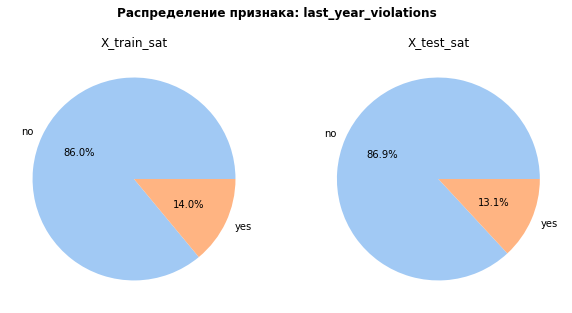

In [43]:
compare_pie(X_train_sat, X_test_sat, 'last_year_violations')

* Соотношение в датасетах одинаковое
* Порядка 13-14% сотрудников нарушали трудовой договор за последний год

Посмотрим на количество нарушений в разбивке по оценке уровня удовлетворенности работой в компании:

job_satisfaction_rate >= 0.7 : 


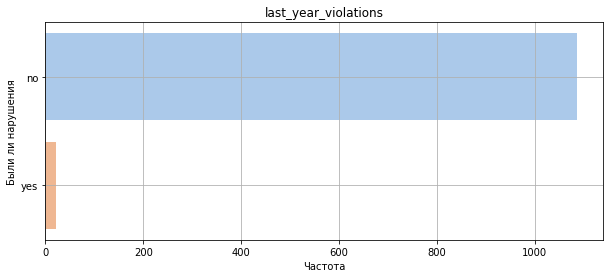

no     0.980144
yes    0.019856
Name: last_year_violations, dtype: float64


job_satisfaction_rate от 0.3 до  0.7 : 


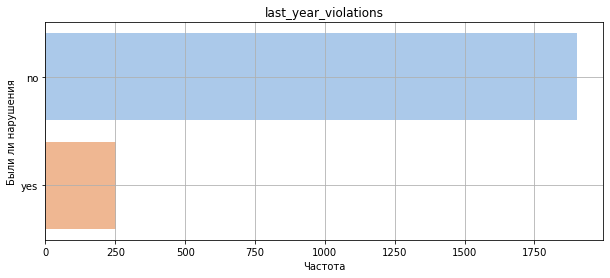

no     0.883418
yes    0.116582
Name: last_year_violations, dtype: float64


job_satisfaction_rate <= 0.3 : 


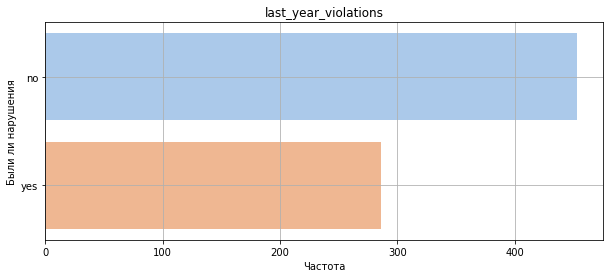

no     0.612991
yes    0.387009
Name: last_year_violations, dtype: float64

In [44]:
print ('job_satisfaction_rate >= 0.7 : ')
make_countplot(X_train_sat.query('job_satisfaction_rate >= 0.7'), 'last_year_violations', 'Были ли нарушения')
display(X_train_sat.query('job_satisfaction_rate >= 0.7')['last_year_violations'].value_counts(normalize=True))

print ('\njob_satisfaction_rate от 0.3 до  0.7 : ')
make_countplot(X_train_sat.query('job_satisfaction_rate > 0.3 and job_satisfaction_rate < 0.7'), 
               'last_year_violations', 'Были ли нарушения')
display(X_train_sat.query('job_satisfaction_rate > 0.3 and job_satisfaction_rate < 0.7')
        ['last_year_violations'].value_counts(normalize=True))

print ('\njob_satisfaction_rate <= 0.3 : ')
make_countplot(X_train_sat.query('job_satisfaction_rate <= 0.3'), 'last_year_violations', 'Были ли нарушения')
display(X_train_sat.query('job_satisfaction_rate <= 0.3')['last_year_violations'].value_counts(normalize=True))

* Нарушения трудового договора чаще производят сотрудники, имеющий низкий уровень удовлетворённости работой в компании

#### supervisor_evaluation

Оценка качества работы сотрудника, которую дал руководитель

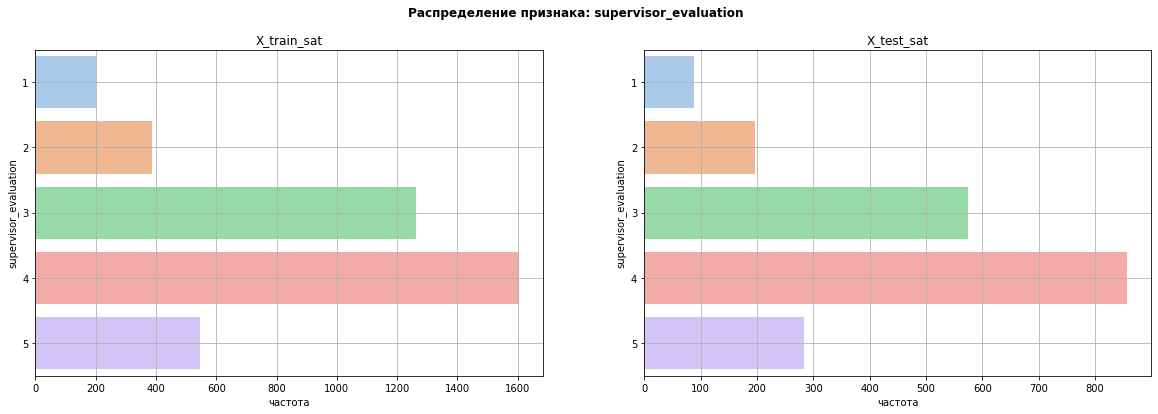

Описательная статистика X_train_sat


,count,mean,std,min,25%,50%,75%,max
supervisor_evaluation,4000.0,3.4765,1.008812,1.0,3.0,4.0,4.0,5.0


Описательная статистика X_test_sat


,count,mean,std,min,25%,50%,75%,max
supervisor_evaluation,2000.0,3.5265,0.996892,1.0,3.0,4.0,4.0,5.0


In [45]:
compare_countplots(X_train_sat, X_test_sat, 'supervisor_evaluation')
print ('Описательная статистика X_train_sat')
display(pd.DataFrame(X_train_sat['supervisor_evaluation'].describe()).T)
print ('Описательная статистика X_test_sat')
pd.DataFrame(X_test_sat['supervisor_evaluation'].describe()).T

* в 70% случаев оценка 3 или 4
* 5 - в 14%
* ниже 3 - в 14%


job_satisfaction_rate <= 0.3 : 


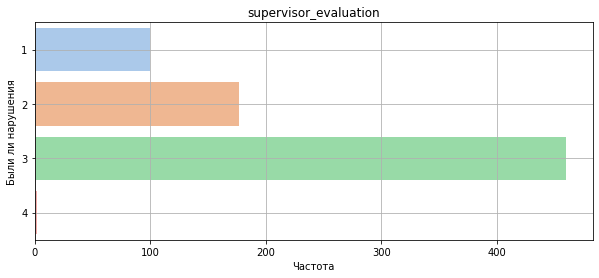


job_satisfaction_rate от 0.3 до  0.7 : 


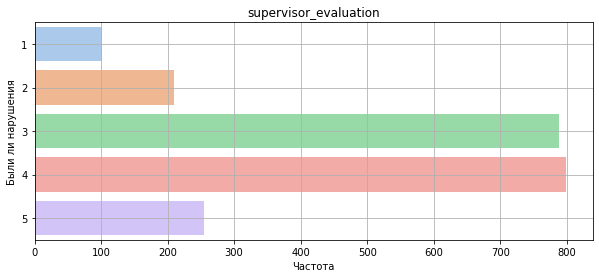

job_satisfaction_rate >= 0.7 : 


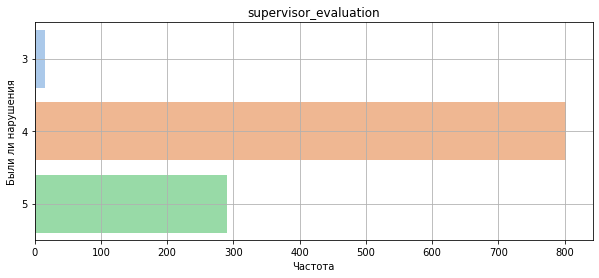

In [46]:
print ('\njob_satisfaction_rate <= 0.3 : ')
make_countplot(X_train_sat.query('job_satisfaction_rate <= 0.3'), 'supervisor_evaluation', 'Были ли нарушения')

print ('\njob_satisfaction_rate от 0.3 до  0.7 : ')
make_countplot(X_train_sat.query('job_satisfaction_rate > 0.3 and job_satisfaction_rate < 0.7'), 
               'supervisor_evaluation', 'Были ли нарушения')

print ('job_satisfaction_rate >= 0.7 : ')
make_countplot(X_train_sat.query('job_satisfaction_rate >= 0.7'), 'supervisor_evaluation', 'Были ли нарушения')

* Сотрудникам, низко оценившим удовлетворенность работой в компании, соответствуют более низкие оценки качества работы от руководителя
* Сотрудники, оценившие удовлетворенность компанией выше 0.7, редко получают оценку качества работы ниже 4.

#### salary

Зарплата

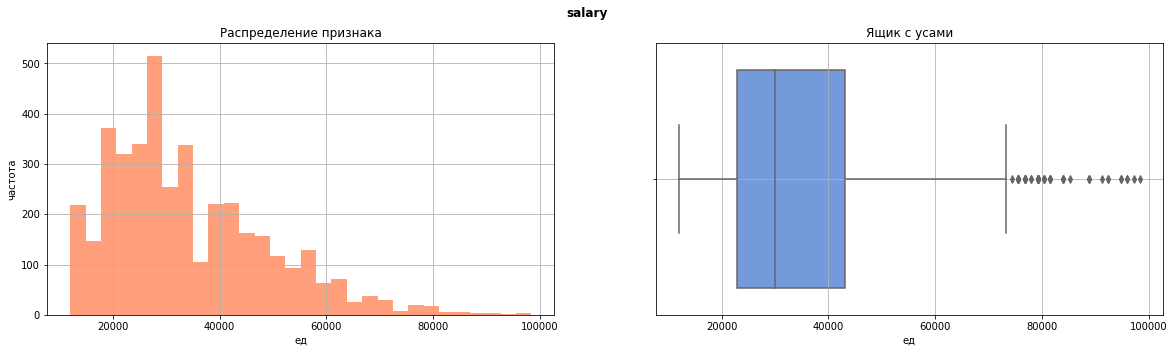

,count,mean,std,min,25%,50%,75%,max
salary,4000.0,33926.7,14900.703838,12000.0,22800.0,30000.0,43200.0,98400.0


In [47]:
make_hist(X_train_sat, 'salary', 30, None, 'ед')
pd.DataFrame(X_train_sat['salary'].describe()).T

* Медианная - 30000
* Средняя - 33926
* Размах - от 12000 до 98400
* 75% сотрудников имеют зарплату ниже 43200

На ящике с усами видим выбросы при значенияя выше 73000.

Составим портрет сотрудника, получающего более 70000 тысяч рублей:

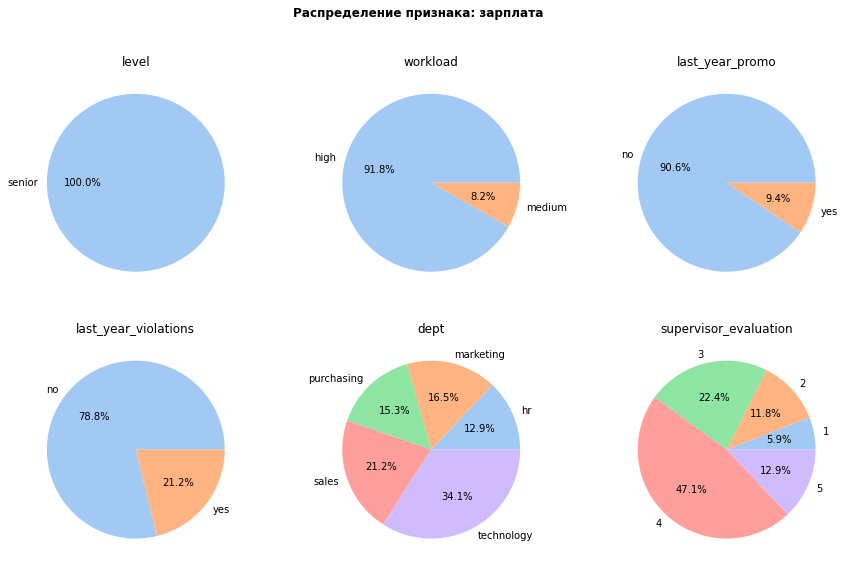

In [48]:
plt.figure(figsize=(15,9))
p=1
titles = ['level', 'workload', 'last_year_promo', 'last_year_violations', 'dept', 'supervisor_evaluation']
for i in titles:
    plt.subplot(2, 3, p)
    plt.suptitle(f'Распределение признака: зарплата', fontweight='bold')
    plt.pie(x=X_train_sat.query('salary>70000').groupby(i)[i].count(), 
            labels=X_train_sat.query('salary>70000').groupby(i)[i].count().index, autopct='%1.1f%%', 
            colors=sns.color_palette('pastel'))
    plt.title(i)
    p +=1
plt.show()

* 100% занимают должность senior,
* 92% - высокая занятость,
* 34% сотрудников из отдела technology (по всей компании лишь 22% сотрудников работают в этом отделе)

Можно сделать вывод, что высокие зарплаты обоснованы, выбросами эти значения назвать нельзя.

#### job_satisfaction_rate

Уровень удовлетворённости сотрудника работой в компании, целевой признак

X_train:


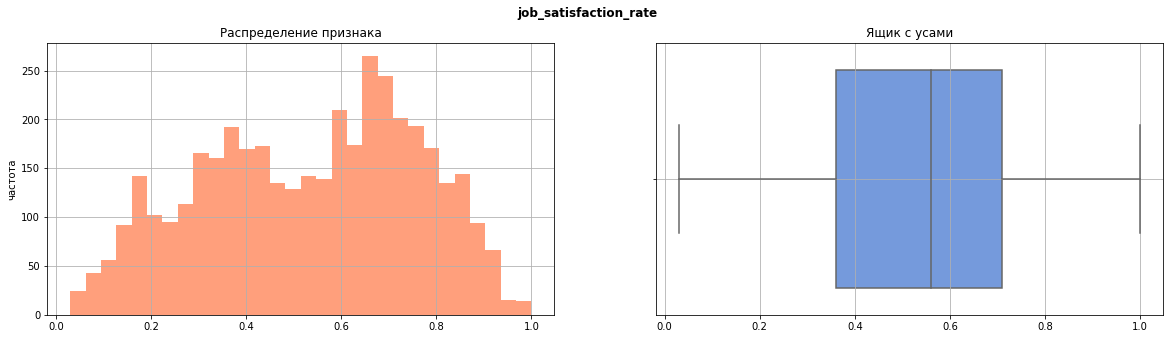

,count,mean,std,min,25%,50%,75%,max
job_satisfaction_rate,4000.0,0.533995,0.225327,0.03,0.36,0.56,0.71,1.0



y_test:


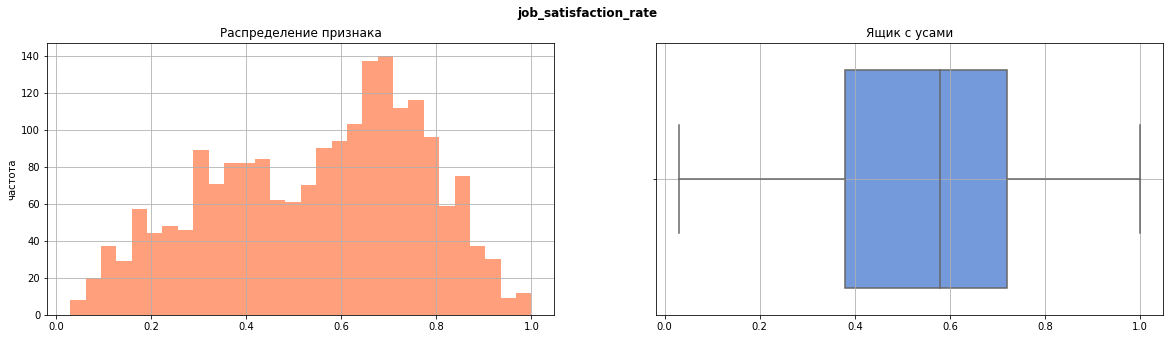

,count,mean,std,min,25%,50%,75%,max
job_satisfaction_rate,2000.0,0.54878,0.22011,0.03,0.38,0.58,0.72,1.0


In [49]:
print ('X_train:')
make_hist(X_train_sat, 'job_satisfaction_rate', 30, None, '')
display(pd.DataFrame(X_train_sat['job_satisfaction_rate'].describe()).T)

print ('\ny_test:')
make_hist(y_test_sat, 'job_satisfaction_rate', 30, None, '')
pd.DataFrame(y_test_sat['job_satisfaction_rate'].describe()).T

* Среднее - 0.53
* Медианное - 0.56
* Половина сотрудников поставила оценки от 0.36 до 0.71
* Распределение в целом равномерное, хотя есть два небольших пика в районе 0.4 и 0.7

Для y_test_sat аналогично.

Построим портеты пользователей по уровню удовлетворенности местом работы.   
Для этого разобьем все оценки из job_satisfaction_rate на 3:
* более 0.7
* между 0.3 и 0.7
* менее 0.3

Построим диаграммы распределения разных признаков при этих условиях и сравним:

<Figure size 1080x648 with 0 Axes>

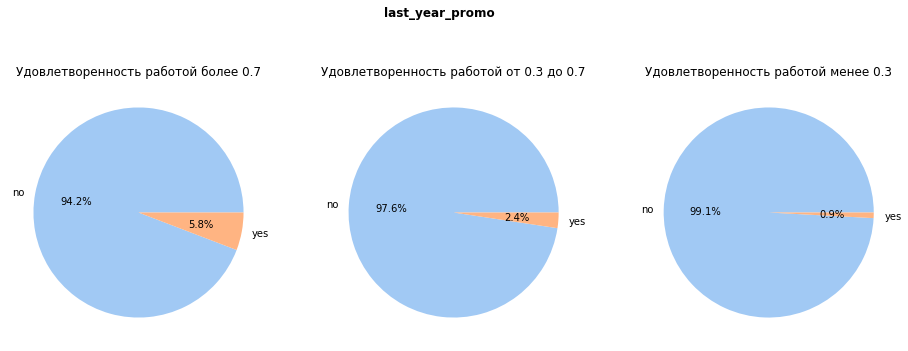

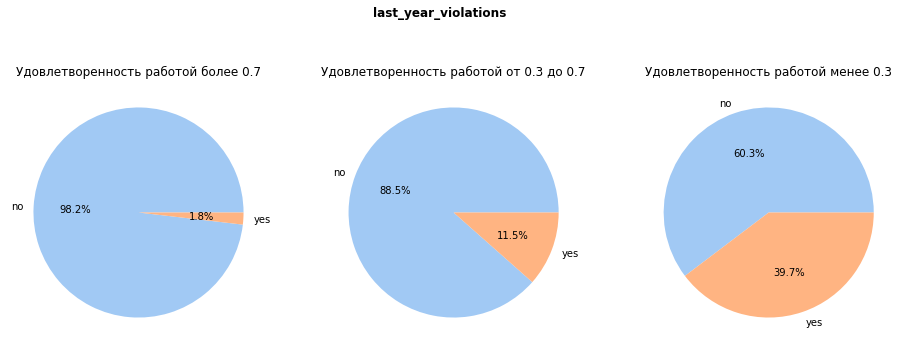

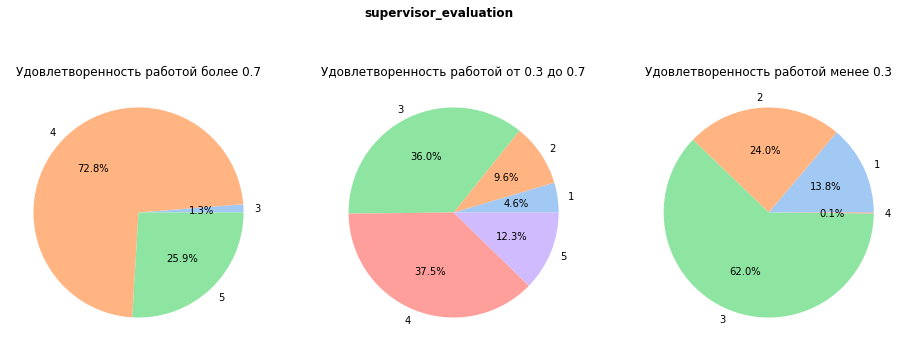

In [50]:
plt.figure(figsize=(15,9))
p=1

titles = ['last_year_promo', 'last_year_violations', 'supervisor_evaluation']
suptitle = ['Удовлетворенность работой более 0.7', 'Удовлетворенность работой от 0.3 до 0.7', 
            'Удовлетворенность работой менее 0.3']
queries = ['job_satisfaction_rate>0.7', 'job_satisfaction_rate>=0.3 and job_satisfaction_rate<=0.7', 
          'job_satisfaction_rate<0.3']

for i in titles:
    f, ax = plt.subplots(1, 3)
    f.set_size_inches(16, 6)
    for q in queries:
        ax[p-1].pie(x=X_train_sat.query(q).groupby(i)[i].count(), 
                labels=X_train_sat.query(q).groupby(i)[i].count().index, autopct='%1.1f%%', 
                colors=sns.color_palette('pastel'))
        ax[p-1].set_title(suptitle[p-1])
        plt.suptitle(i, fontweight = 'bold')
        p +=1
    p=1
    plt.show()


Видим, что сотрудники, более низко оценившие удовлетворенность работой:
* незначительно реже получали повышение
* чаще нарушали трудовой договор
* получали более низкие оценки работы от руководителей

#### **Вывод по 3 разделу**

Значения всех признаков, в том числе целевого, распределены в датасетах в одинаковых пропорциях.

**dept:**
* 38% из отдела продаж - sales
* 22% из technology
* 13-15% из marketing и purchasing
* 11.3% hr - наименьшее количество

**level:**
* 43% middle и 48% junior.  
* Senior - всего  8.6 - 9%

**workload:**
* Половина работников имеют занятость уровня medium.
* Треть - low
* Менее 20% - high

**employment_years:**   
45% сотрудников имеют стаж не более 2 лет.   
Однако, если разбить этот признак по занимаемым должностям, картина получается следующая:   
* Junior: 75% работают 1-2 года, max - 5 
* Middle: в 50% случаев работают от 3 до 7 лет, max - 10 лет
* Senior: в 50% случаев работают от 4 до 8 лет, max - 10 лет

**last_year_promo:**
* 5% сотрудников уровня middle повышены в последний год
* 8.5% сотрудников уровня senior повышены в последний год

**last_year_violations:**
* Порядка 13-14% сотрудников нарушали трудовой договор за последний год
* Нарушения трудового договора чаще производят сотрудники, имеющий низкий уровень удовлетворённости работой в компании
  * в 39% случаев при уровне удовлетворенности работой менее 0.3

**supervisor_evaluation:**
* 70% оценок - 3 или 4, 14% - 5, 14% - ниже 3
* Сотрудникам, низко оценившим удовлетворенность работой в компании, соответствуют более низкие оценки качества работы от руководителя
* Сотрудники, оценившие удовлетворенность компанией выше 0.7, редко получают оценку качества работы ниже 4.

**salary:**
* Медианная - 30000
* Средняя - 33926
* Размах - от 12000 до 98400
* 75% сотрудников имеют зарплату ниже 43200

**job_satisfaction_rate, целевой признак:**
* Среднее - 0.53, Медианное - 0.56
* Половина сотрудников поставила оценки от 0.36 до 0.71
* Распределение в целом равномерное, хотя есть два небольших пика в районе 0.4 и 0.7

Сотрудники, более низко оценившие удовлетворенность работой:
* незначительно реже получали повышение
* чаще нарушали трудовой договор
* получали более низкие оценки работы от руководителей



На этапе подготовке признаков необходимо будет провести:
* масштабирование числовых признаков ('employment_years', 'supervisor_evaluation', 'salary')
* кодирование через ohe_pipe ('last_year_promo', 'last_year_violations', 'dept')
* порядковое кодирование через ord признаков ('level', 'workload')

... и преобразовать датасеты:
* убрать таргет из тренировочной выборки, выделив его в y_train

### **Корреляционный анализ**

Уберем столбец `id`, сделав его индексом:

In [51]:
X_train_sat = X_train_sat.set_index('id')
X_test_sat = X_test_sat.set_index('id')
y_test_sat = y_test_sat.set_index('id')

Создадим вспомогательную таблицу test_sat_full, где объединим входные и целевой признаки тестовой выборки:

In [52]:
test_sat_full = X_test_sat.sort_values(by='id').merge(y_test_sat.sort_values(by='id'), on='id')
test_sat_full.head(3)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.80
100480,marketing,junior,low,4,no,no,4,16800,0.84
100503,purchasing,middle,high,5,no,no,4,55200,0.79


Построим матрицы корреляции и визуализируем зависимости через scatterplot. для выборок:

1. **train**

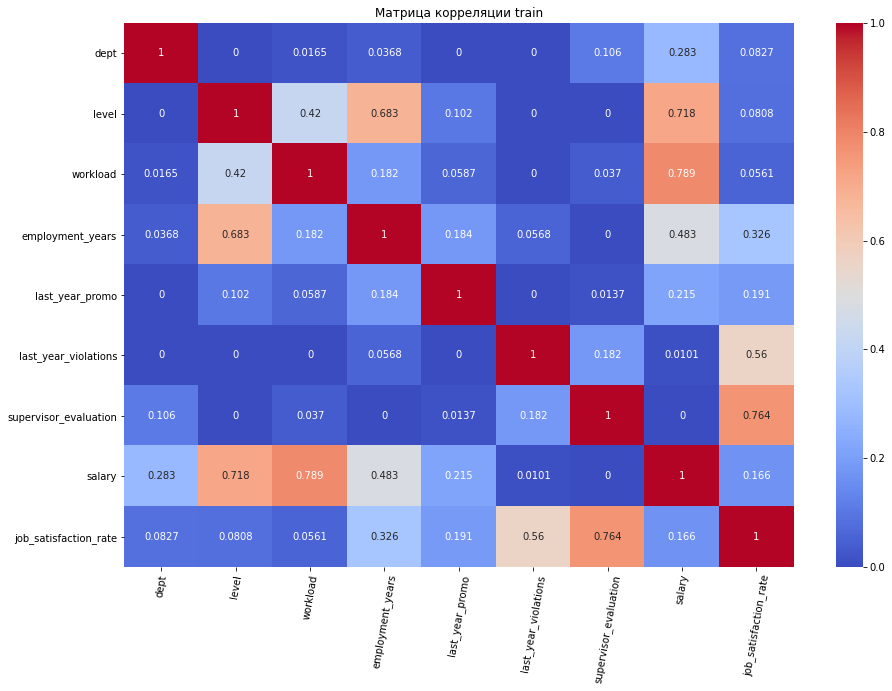

In [53]:
figsize = (8,8)
fig, ax = plt.subplots(figsize=(15,10))
plt.title('Матрица корреляции train')
sns.heatmap(X_train_sat.phik_matrix(interval_cols=interval_cols), ax=ax, annot=True, fmt='.3g', cmap='coolwarm')
plt.xticks(rotation=80)
plt.show()

Входные признаки, наиболее коррелирующие с целевым:
* 0.764 - supervisor_evaluation
* 0.56 - last_year_violations

Средняя/слабая корреляция:
* 0.326 - employment_years

Мультиколлинеарность между входными признаками не наблюдается.

Визуализируем зависимости через scatterplot.

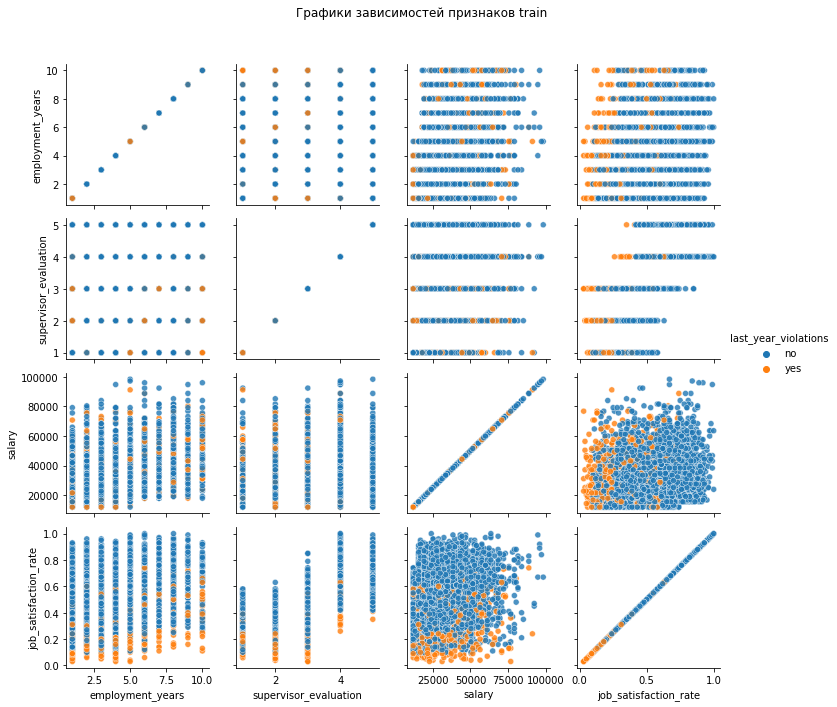

In [54]:
g = sns.PairGrid(X_train_sat, hue='last_year_violations')
g.map(sns.scatterplot, alpha=0.8, color='green')
g.add_legend()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Графики зависимостей признаков train')
plt.show()

Зависимость целевого признака от оценки руководителя (supervisor_evaluation) есть, но не сильно похожа на линейную.

Зависимость от лет, проведенных в компании слабая, не похожа на линейную. Но редко встречается оценка ниже 0.1 при стаже свыше 6 лет.

Среди сотрудников, получивших повышение за прошедший год, крайне редко встречаются оценки удовлетворенности ниже 0.2

2. **test**

Матрица корреляции для тестовой выборки:

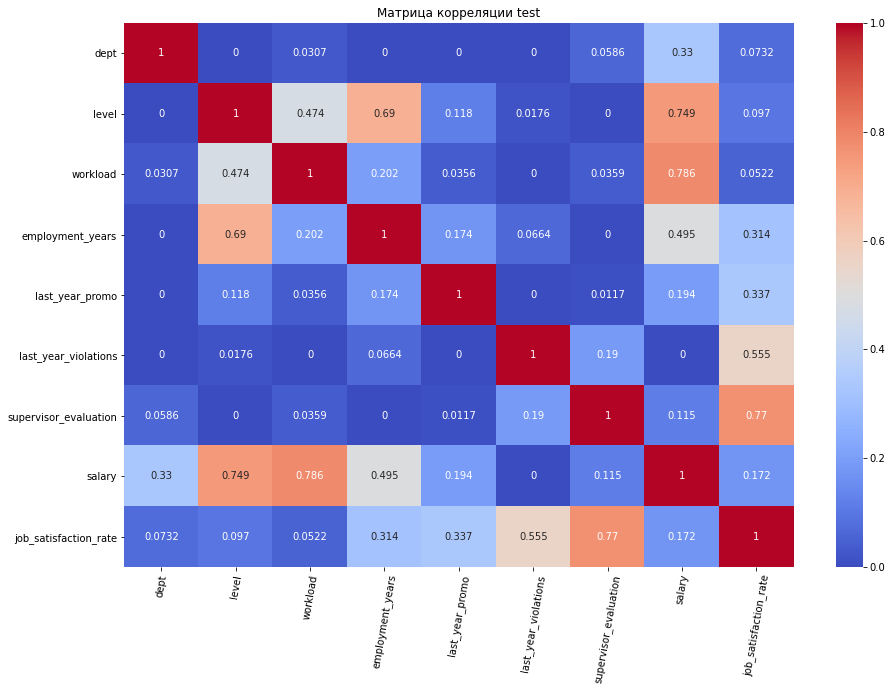

In [55]:
figsize = (8,8)
fig, ax = plt.subplots(figsize=(15,10))
plt.title('Матрица корреляции test')
sns.heatmap(test_sat_full.phik_matrix(interval_cols=interval_cols), ax=ax, annot=True, fmt='.3g', cmap='coolwarm')
plt.xticks(rotation=80)
plt.show()

Входные признаки, наиболее коррелирующие с целевым:
* 0.77 - supervisor_evaluation
* 0.56 - last_year_violations

Средняя/слабая корреляция:
* 0.314 - employment_years
* 0.337 - last_year_promo

* Также не наблюдается мультиколлениарность.



Кажется, что зависимости целевого от входящих признаков, а также между входящими, примерно одинаковые в обеих выборках.

Убедимся в этом, построив дополнительно матрицу разности корреляций между train и test, где для каждого пересечения двух признаков укажем, насколько значение корреляции в test ниже, чем аналогичное в train:

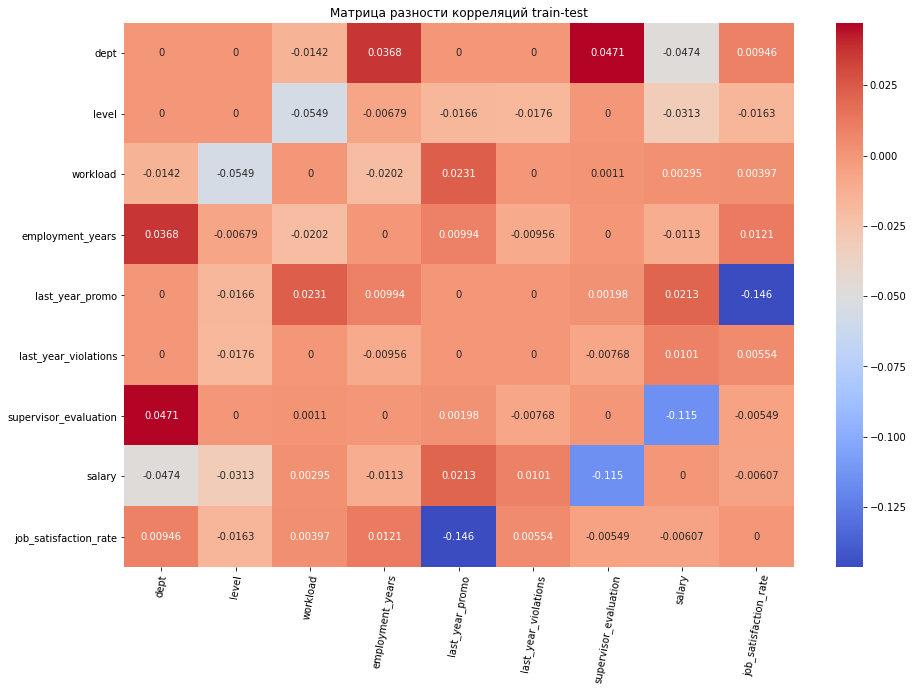

In [56]:
phik_difference = (
    X_train_sat.phik_matrix(interval_cols=interval_cols) - test_sat_full.phik_matrix(interval_cols=interval_cols)
)

figsize = (8,8)
fig, ax = plt.subplots(figsize=(15,10))
plt.title('Матрица разности корреляций train-test')
sns.heatmap(phik_difference, ax=ax, annot=True, fmt='.3g', cmap='coolwarm')
plt.xticks(rotation=80)
plt.show()

* Максимальные отклонения - до 15% в 2 случаях.

В остальном значения различаются менее чем на 10%.

Строим графики зависимостей признаков test:

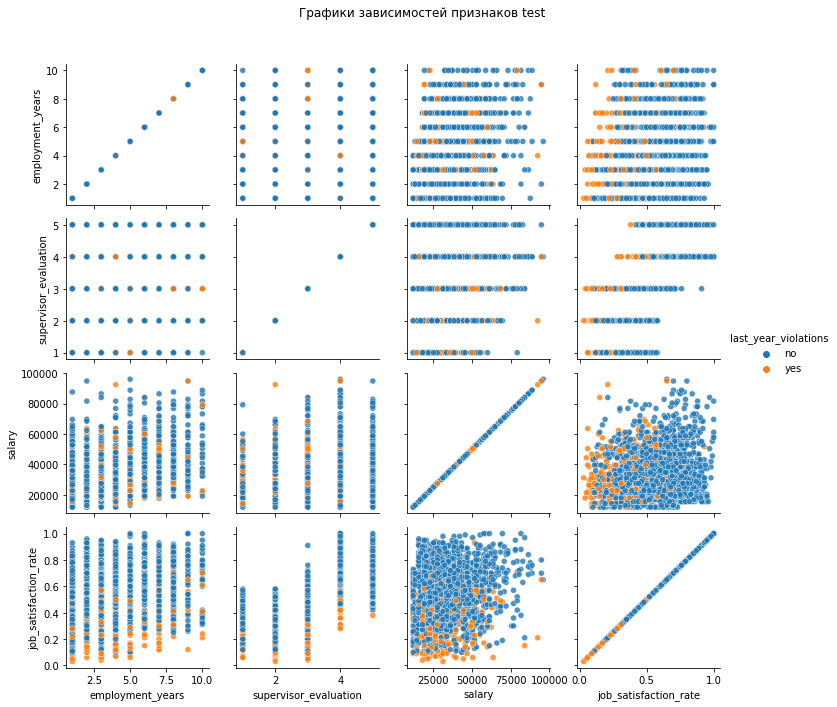

In [57]:
g = sns.PairGrid(test_sat_full, hue='last_year_violations')
g.map(sns.scatterplot, alpha=0.8, color='green')
g.add_legend()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Графики зависимостей признаков test')
plt.show()

Ситуация та же, что и в train.

#### Вывод по 4 разделу

Входные признаки, наиболее коррелирующие с целевым:
* 0.764 - supervisor_evaluation
* 0.56 - last_year_violations

Средняя/слабая корреляция:
* 0.326 - employment_years

Мультиколлинеарность между входными признаками не наблюдается.

Зависимость целевого признака от оценки руководителя (supervisor_evaluation) есть, но не сильно похожа на линейную.

Зависимость от лет, проведенных в компании слабая, не похожа на линейную. Но редко встречается оценка ниже 0.1 при стаже свыше 6 лет.

Среди сотрудников, получивших повышение за прошедший год, крайне редко встречаются оценки удовлетворенности ниже 0.2


**test:**

Зависимости целевого от входящих признаков, а также между входящими, примерно одинаковые в обеих выборках.
* Максимальные отклонения - до 15% в 2 случаях.
* В остальном значения различаются менее чем на 10%.

### **Подготовка признаков**

Разделим train на X и Y:

In [58]:
X_train_lr = X_train_sat.copy()
y_train_lr = X_train_lr['job_satisfaction_rate']
X_train_lr = X_train_lr.drop('job_satisfaction_rate', axis=1)

print ('X_train_lr, shape=', X_train_lr.shape)
display(X_train_lr.head(3))
print ('y_train_lr, shape=', y_train_lr.shape)
display(y_train_lr.head(3))

X_train_lr, shape= (4000, 8)


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000
653870,hr,junior,high,2,no,no,5,38400
184592,sales,junior,low,1,no,no,2,12000


y_train_lr, shape= (4000,)


id
155278    0.58
653870    0.76
184592    0.11
Name: job_satisfaction_rate, dtype: float64

Тестовые данные сохраним в новые переменные, сделав копии:

In [59]:
# Сортируем, чтобы последовательность значений была одинакова 
X_test_lr = X_test_sat.copy().sort_values(by='id')
y_test_lr = y_test_sat.copy().sort_values(by='id')['job_satisfaction_rate']

print ('X_test_lr, shape=', X_test_lr.shape)
display(X_test_lr.head(3))
print ('y_test_lr, shape=', y_test_lr.shape)
display(y_test_lr.head(3))

X_test_lr, shape= (2000, 8)


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200
100480,marketing,junior,low,4,no,no,4,16800
100503,purchasing,middle,high,5,no,no,4,55200


y_test_lr, shape= (2000,)


id
100298    0.80
100480    0.84
100503    0.79
Name: job_satisfaction_rate, dtype: float64

#### Пайплайн для подготовки данных

Списки с названиями признаков:

In [60]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

print ('ohe_columns:\n', ohe_columns)
print ('\nord_columns:\n', ord_columns)
print ('\nnum_columns:\n', num_columns)

ohe_columns:
 ['dept', 'last_year_promo', 'last_year_violations']

ord_columns:
 ['level', 'workload']

num_columns:
 ['employment_years', 'supervisor_evaluation', 'salary']


Пайплайны для подготовки признаков из списка ohe_columns и ord_columns:

In [61]:
ohe_pipe = Pipeline(
    [
        ('SimpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')), 
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

In [62]:
ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(categories=[
            ['junior', 'middle', 'senior'],
            ['low', 'medium', 'high']
        ], handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

Объединение шагов подготовки:

In [63]:
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns), 
    ('ord', ord_pipe, ord_columns), 
    ('num', StandardScaler(), num_columns)
], 
    remainder='passthrough'
)

Финальный пайплайн:

In [64]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor), 
    ('models', LinearRegression())
])

### **Обучение модели**

**Создание метрики:**

SMAPE (англ. symmetric mean absolute percentage error)  
* Симметричное среднее абсолютное процентное отклонение

Функция для рассчета:

In [65]:
def smape(y_true, y_pred):
    metric = 100 * np.sum(
        ((np.abs(y_true-y_pred))/((np.abs(y_true)+np.abs(y_pred))/2))
    ) / len(y_true)
    
    return metric

Создаем пользовательскую метрику. Указываем greater_is_better=False, т.к. наша цель - получить низкие значения метрики.

In [66]:
smape_scorer = make_scorer(smape, greater_is_better=False)

**Задаем модели и их гиперпараметры для перебора:**

Для решения задачи линейной регрессии нам подойдут модели LinearRegression и DecisionTreeRegressor:

In [67]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    ## макс. глубина и количество функций
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(3, 15),
        'models__max_features': range(3, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },

    # LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    } 
]

**Запуск автоматического подбора:**


Поскольку гиперпараметров не очень много, перебор всех не должен занять слишком много времени, поэтому подбор осуществим с помощью GridSearchCV:

In [68]:
grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,
    n_jobs=-1
)
grid_search.fit(X_train_lr, y_train_lr)

# Сохраним список моделей
lr_models = pd.DataFrame(grid_search.cv_results_)

# Выведем на экран параметры лучшей модели и значение метрики
print ('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)

# Выведем на экран 5 лучших моделей
print ('\n5 лучших моделей и их значения метрики:')
display(pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score')[[
    'param_preprocessor__num', 'param_models__max_features', 'param_models__max_depth', 'param_models',
'mean_test_score', 'std_test_score', 'rank_test_score']].head())

# Выведем на экран значение метрики лучшей модели
print ('Метрика лучшей модели при кросс-валидации:\n', round(grid_search.best_score_*(-1), 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('SimpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

,param_preprocessor__num,param_models__max_features,param_models__max_depth,param_models,mean_test_score,std_test_score,rank_test_score
261,MinMaxScaler(),13.0,13.0,DecisionTreeRegressor(random_state=42),-15.012640,0.314872,1
263,MinMaxScaler(),14.0,13.0,DecisionTreeRegressor(random_state=42),-15.012640,0.314872,1
259,MinMaxScaler(),12.0,13.0,DecisionTreeRegressor(random_state=42),-15.012640,0.314872,1
257,MinMaxScaler(),11.0,13.0,DecisionTreeRegressor(random_state=42),-15.012640,0.314872,1
260,StandardScaler(),13.0,13.0,DecisionTreeRegressor(random_state=42),-15.030417,0.270229,5


Метрика лучшей модели при кросс-валидации:
 15.01


**Результат при кросс-валидации:**

Значение метрики SMAPE равно 15.01 - пока недостаточно хорошо, проверим далее на тестовой выборке. 

Лучшей оказалась следующая модель:  
* DecisionTreeRegressor
* param_models__max_features = 11
* param_models__max_depth = 13
* MinMaxScaler

#### Применение модели к тестовым данным

**Метрика SMAPE на тестовых данных:**

In [69]:
# Прогнозируем значения к X_test_lr и считаем метрику
y_pred_lr = grid_search.best_estimator_.predict(X_test_lr)
print ('SMAPE лучшей модели на тестовой выборке:\n', round(smape(y_test_lr, y_pred_lr), 2))


SMAPE лучшей модели на тестовой выборке:
 14.28


* Результат приемлемый. Целью было достичь значения метрики не более 15.

Проведем проверку на адекватность с помощью DummyRegression():

In [70]:
dummy_lr = DummyRegressor(strategy = 'mean')
dummy_lr.fit(X_train_lr, y_train_lr)
y_pred_dummy = dummy_lr.predict(X_test_lr)

print ('SMAPE при DummyRegression:\n', round(smape(y_test_lr, y_pred_dummy), 2))

SMAPE при DummyRegression:
 38.22


* Модель, всегда предсказывающая среднее значение целевых значений, выдает значительно худший результат метрики - 38.22.

Наша лучшая модель DecisionTreeRegressor работает значительно более качественно. Проверка на адекватность пройдена.

Визуализируем результаты и проведем анализ остатков:

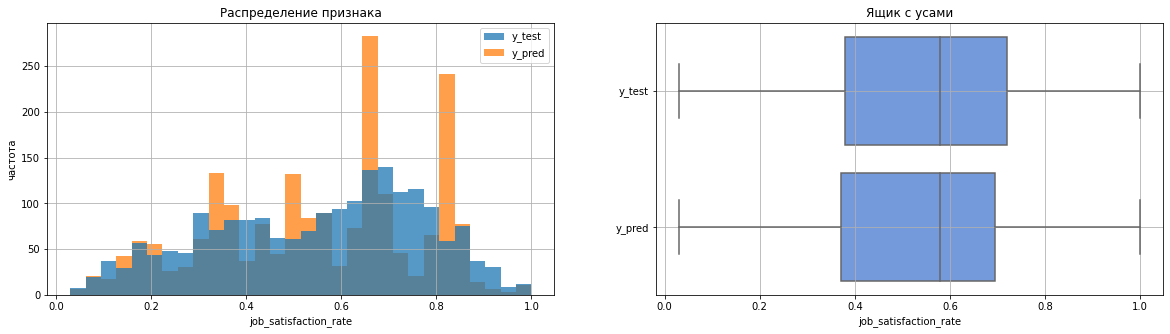

,count,mean,std,min,25%,50%,75%,max
y_test,2000.0,0.548780,0.220110,0.03,0.38,0.580000,0.720000,1.0
y_pred,2000.0,0.551315,0.216001,0.03,0.37,0.579091,0.695625,1.0


In [71]:
# Объединим в одну таблицу test и pred
y_joint = pd.DataFrame(list(zip(y_test_lr, y_pred_lr)), columns=['y_test', 'y_pred'])

make_hist(y_joint, None, 30, None, 'job_satisfaction_rate')
y_joint.describe().T

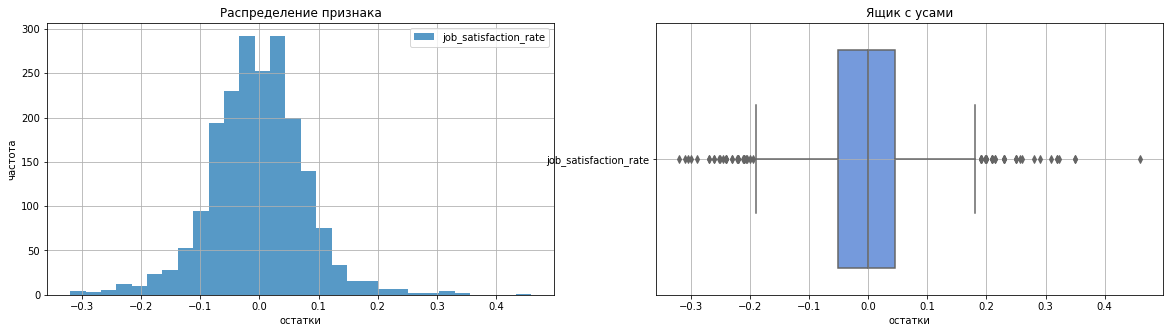

,count,mean,std,min,25%,50%,75%,max
job_satisfaction_rate,2000.0,-0.002535,0.080417,-0.32,-0.050577,0.0,0.045,0.46


In [72]:
make_hist(pd.DataFrame(y_test_lr - y_pred_lr), None, 30, None, 'остатки')
pd.DataFrame((y_test_lr - y_pred_lr).describe()).T

Остатки нормально распределены.  
Среднее практически равно нулю.  
Стандартное отклонение - 0.08. Т.е. не более 10%.  

В 50% случаев отклонение не более 0.1.

#### **Вывод по 5 разделу**

Определена лучшая модель и предсказаны значения для тестовых данных.  

**Результат:**

Лучшая модель:
* DecisionTreeRegressor
* param_models__max_features = 11
* param_models__max_depth = 13
* MinMaxScaler

Итог работы по метрике SMAP на кросс-валидационной выборке:
* 15.01

Итог работы по метрике SMAP на тестовых данных:
* 14.28

Анализ остатков:
* Остатки нормально распределены.  
* Среднее практически равно нулю.  
* Стандартное отклонение - 0.08. Т.е. не более 10%.  

* В 50% случаев отклонение не более 0.1.

* Макс. отклонения: -0.32; 0.46

**Почему эта модель оказалась лучшей:**
* для дерева решений перебирались гиперпараметры, поэтому её удалось лучше настроить и найти наилучшее решение. 

**Детали:**

Подготовка данных осуществлялась кодировкой...: 
* OneHotEncoder (столбцы 'dept', 'last_year_promo', 'last_year_violations'), 
* OrdinalEncoder (столбцы 'level', 'workload')   
... и масштабированием:
* Min_Max_encoder

Поиск лучшей модели осуществлен через перебор гиперпараметров:
* Модель LinearRegression():
  * Скейлеры: StandardScaler(), MinMaxScaler()
* Модель DecisionTreeClassifier():
  * 'models__max_depth': от 3 до 15
  * 'models__max_features': от 3 до 15
  * Скейлеры: StandardScaler(), MinMaxScaler()

Перебор гиперпараметров через GridSearchCV.

Метрика:  
SMAPE - симметричное среднее абсолютное процентное отклонение
* Среднее значение отношения модуля разницы фактического и предсказанного значений к половине суммы модулей фактического и предсказанного значений, умноженное на 100.

## **Часть 2**

Предсказание увольнения сотрудника из компании.

### **Загрузка данных**

Загрузим данные

In [73]:
X_train_quit = pd.read_csv('/datasets/train_quit.csv')
X_test_quit = pd.read_csv('/datasets/test_features.csv')
y_test_quit = pd.read_csv('/datasets/test_target_quit.csv')

#### X_train_quit

Изучим:

In [74]:
show_info(X_train_quit)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


* 4000 строк
* 10 колонок, включая id

Типы данных, количество столбцов:  
1. object, 5 столбцов
  * `dept`, `level`, `workload`, `last_year_promo`, `last_year_violations`, `quit`
2. int, 4 столбца
  * `id`, `employment_years`, `supervisor_evaluation`, `salary`

Пропусков нет.

Типы данных корректны.   

Наименования столбцов корректные, стилистика соблюдается.

Целевой признак - `quit`

Признаковое описание (входные признаки) такое же, что и в X_train_sat. 

Проверим, совпадают ли `id` нового датасета X_train_quit и с старого X_train_sat:

In [75]:
help_list = X_train_quit['id'].to_list()

X_train_sat.query('id in @help_list')

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,


* Повторяющихся `id` нет.

#### X_test_quit

В описании датасета указано, что он полностью совпадает с предыдущим X_test_sat.  
Проверим:

In [76]:
show_info(X_test_quit)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


2000 строк, 9 столбцов.

Датасет по количеству строк в два раза меньше тренировочного.  
Столбцов - такое же количество минус целевой признак.

Типы данных, количество столбцов:  
1. object, 5 столбцов
  * `dept`, `level`, `workload`, `last_year_promo`, `last_year_violations`
2. int, 4 столбца
  * `id`, `employment_years`, `supervisor_evaluation`, `salary`

Незаполненные значения в столбцах:
`dept`, `level`

Типы данных корректны.   

Наименования столбцов корректные, стилистика соблюдается.

Проверим, что `id` X_test_sat и X_test_quit совпадают:

In [77]:
help_list = X_test_sat.reset_index()['id']
X_test_quit.query('id in @help_list').shape

(2000, 9)

* Совпадают:  
  Совпадают размеры изначального X_test_quit и X_test_quit, в котором есть только `id`, присутствующие также и в X_test_sat

#### y_test_quit

Целевой признак тестовой выборки.

In [78]:
show_info(y_test_quit)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


2000 строк, 2 колонки:

`id` и целевой признак `quit`

Типы данных и наименования столбцов в порядке.

Проверяем совпадения по id:

In [79]:
y_test_quit.query('id in @help_list').shape

(2000, 2)

* Всё в порядке.

#### **Вывод по 2.1 разделу**

Входящие данные тестовой выборки X_test_quit польностью совпадают с датасетом X_test_sat.

Датасет с тренировочными данными X_train_quit имеет такое же признаковое описание, как и в X_train_sat, но другие `id` и целевой признак - `quit` (yes/no).

Датасет y_test_quit состоит польностью из значений целевого признака `quit`, строки совпадают по `id` с X_train_quit.

Типы данных, наименования строк корректны.

В X_test_quit присутствует по крайней мере 3 пропуска, необходимо обработать на следующем шаге.

### **Предобработка данных**

**Явные дубликаты:**

In [80]:
duplicates_find(X_train_quit)

Явных дубликатов не найдено


**Неявные дубликаты:**

In [81]:
uniques(X_train_quit)

dept: 
 ['sales' 'purchasing' 'marketing' 'technology' 'hr'] 
 
level: 
 ['middle' 'junior' 'sinior'] 
 
workload: 
 ['high' 'medium' 'low'] 
 
last_year_promo: 
 ['no' 'yes'] 
 
last_year_violations: 
 ['no' 'yes'] 
 
quit: 
 ['no' 'yes'] 
 


Меняем опечатку "sinior"-"senior"

In [82]:
X_train_quit['level'] = X_train_quit['level'].replace('sinior', 'senior')
X_train_quit['level'].unique()

array(['middle', 'junior', 'senior'], dtype=object)

**Пропуски:**

In [83]:
X_train_quit.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

* пропусков нет

#### X_test_quit

**Явные дубликаты:**

In [84]:
duplicates_find(X_test_quit)

Явных дубликатов не найдено


**Неявные дубликаты:**

In [85]:
uniques(X_test_quit)

dept: 
 ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' '] 
 
level: 
 ['junior' 'middle' 'sinior' nan] 
 
workload: 
 ['medium' 'low' 'high' ' '] 
 
last_year_promo: 
 ['no' 'yes'] 
 
last_year_violations: 
 ['no' 'yes'] 
 


1. Исправляем опечатку

In [86]:
X_test_quit['level'] = X_test_quit['level'].replace('sinior', 'senior')
X_test_quit['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

2. меняем пропуски на nan, заполняем модой

In [87]:
X_test_quit['dept'] = X_test_quit['dept'].replace(' ', np.nan)
X_test_quit['workload'] = X_test_quit['workload'].replace(' ', np.nan)

In [88]:
# Обучаем imp_pipe на train
imp_pipe.fit(X_train_quit[['dept', 'level', 'workload']])

X_test_quit[['dept', 'level', 'workload']] = imp_pipe.transform(X_test_quit[['dept', 'level', 'workload']])
uniques(X_test_quit)

dept: 
 ['marketing' 'hr' 'sales' 'purchasing' 'technology'] 
 
level: 
 ['junior' 'middle' 'senior'] 
 
workload: 
 ['medium' 'low' 'high'] 
 
last_year_promo: 
 ['no' 'yes'] 
 
last_year_violations: 
 ['no' 'yes'] 
 


* пропусков не видим

#### y_test_quit

**Явные дубликаты:**

In [89]:
duplicates_find(y_test_quit)

Явных дубликатов не найдено


**Неявные дубликаты:**

In [90]:
uniques(y_test_quit)

quit: 
 ['yes' 'no'] 
 


* Только два уникальных значения - нет и да.  
Все соответствует описанию задачи.

#### **Вывод по 2.2 разделу**

1. Исправлены опечатки в X_train_quit X_test_quit: 'sinior' - 'senior'.
2. Заполнены пропуски в X_test_quit.
3. Пропущенные значения в X_test_quit также заменены на наиболее популярное значение с помощью пайплайна.

Явных дубликатов не обнаружено.

### **Исследовательский анализ данных**

#### Анализ


Для объектов типа Object построим диаграммы распределения значений признаков для X_train_quit и X_test_quit,  в сравнении с X_train_sat.  

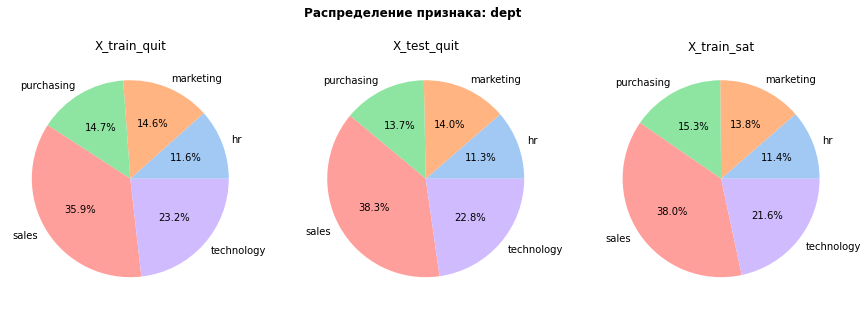

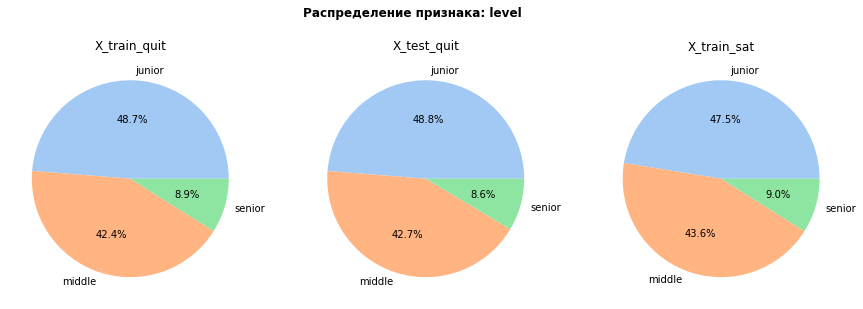

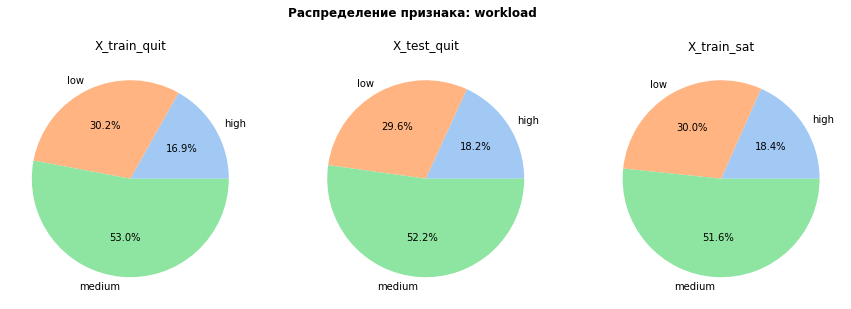

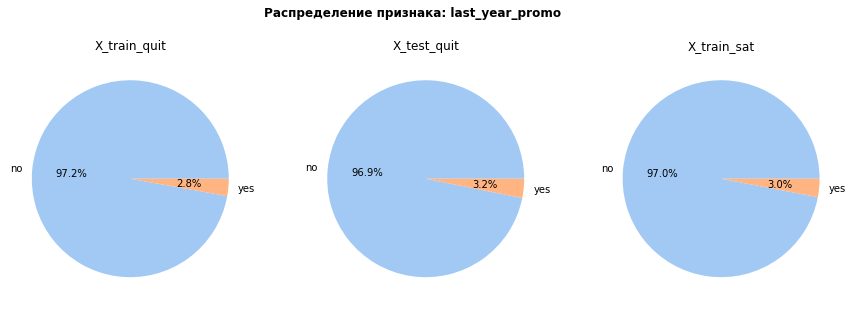

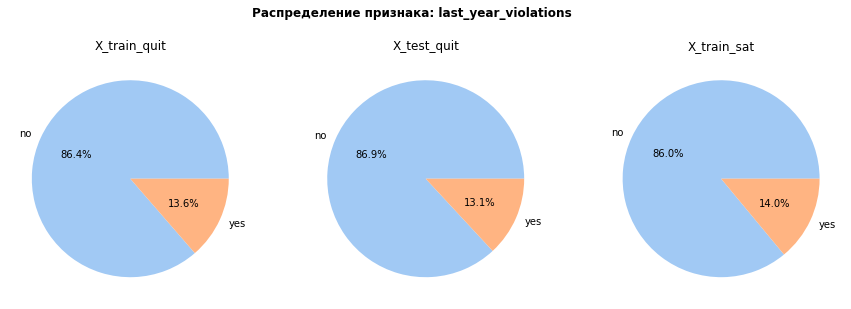

In [91]:
titles_for_pie = ['X_train_quit', 'X_test_quit', 'X_train_sat']
for i in X_train_quit.drop(['id', 'quit'], axis=1):
    if X_train_quit[i].dtype == 'O':
        compare_pie_3(X_train_quit, X_test_quit, X_train_sat, i)

В новых датасетах данные также распределены по признакам пропорционально.

Видно, что распределения признаков типа object остались в той же пропорции, что были в шаге 1.3 для датасета с целевым признаком "jod_satisfaction_rate":
* больше всего сотрудников в отделе продаж
* Junior - 49%, middle - 42%, senior - 9%
* В половине случаев у сотрудников средняя нагрузка
* Повышались за последний год лишь 3% сотрудников
* Нарушали трудовой договор - 13%

Теперь то же самое для распределения признаков `employment_years` и `supervisor_evaluation`:

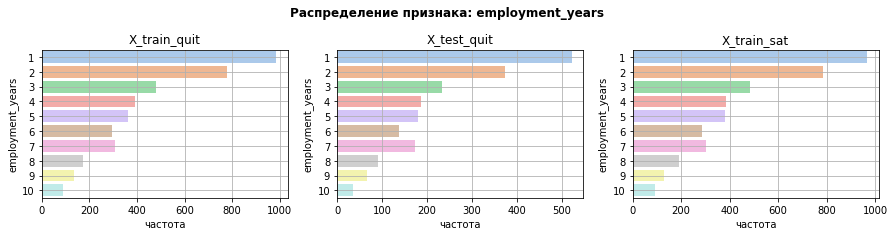

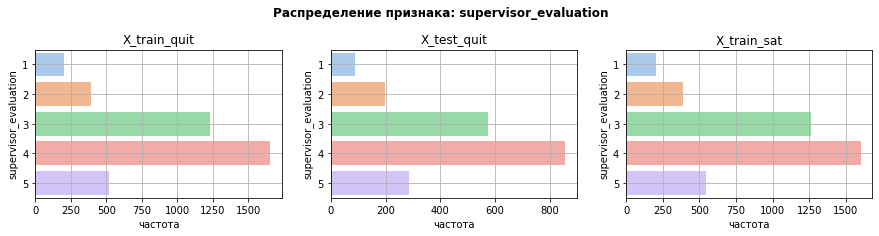

In [92]:
titles_for_countplots = ['X_train_quit', 'X_test_quit', 'X_train_sat']

for y in X_train_quit[['employment_years', 'supervisor_evaluation']]:
    plt.figure(figsize=(15, 6))
    p=1
    for i in [X_train_quit, X_test_quit, X_train_sat]:
        plt.subplot(2, 3, p)
        plt.suptitle(f'Распределение признака: {y}', fontweight='bold')
        sns.countplot(y=y, data=i, palette='pastel')
        plt.title(titles_for_countplots[p-1])
        plt.xlabel('частота')
        plt.grid()
        p +=1
    plt.show()

Данные распределены в одинаковых пропорциях в тренировочных и тестовых данных с таргетом `quit`, распределение такое же, как и в датасетах из первой части задачи.

Длительность работы сотрудника:
* Наибольшее количество 1 год. Далее - по убыванию (за исключением 7).

Оценки от руководителя:
* Преимущественно 4 и 5

**Зарплата:**

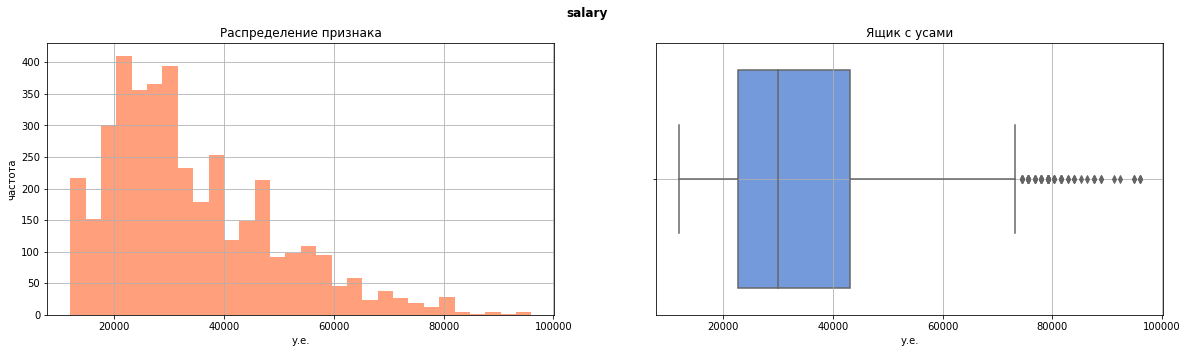

,count,mean,std,min,25%,50%,75%,max
salary,4000.0,33805.8,15152.415163,12000.0,22800.0,30000.0,43200.0,96000.0


In [93]:
make_hist(X_train_quit, 'salary', 30, None, 'у.е.')
pd.DataFrame(X_train_quit['salary'].describe()).T

* Сильных изменений в сравнении с данными в п. 1.3.8 не наблюдается.

**Целевой признак - `quit`**

Посмотрим, как часто встречаются 0 и 1 классы таргетов в наших тренировочной и тестовой выборках:

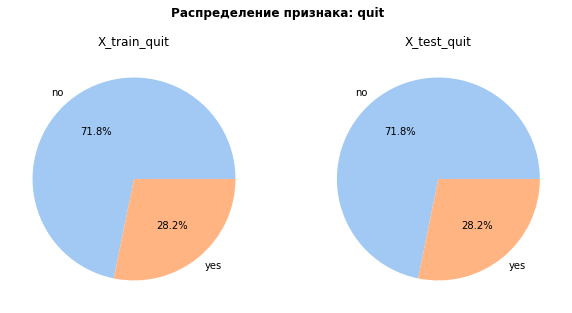

In [94]:
compare_pie(X_train_quit, y_test_quit, 'quit')

* Почти 70 на 30.

Из предоставленного списка уволились порядка 28% сотрудников.

#### Портрет «уволившегося сотрудника»

Сравним распределение признаков датасета в разрезе сотрудников уволившихся/не уволившихся и в совокупности:

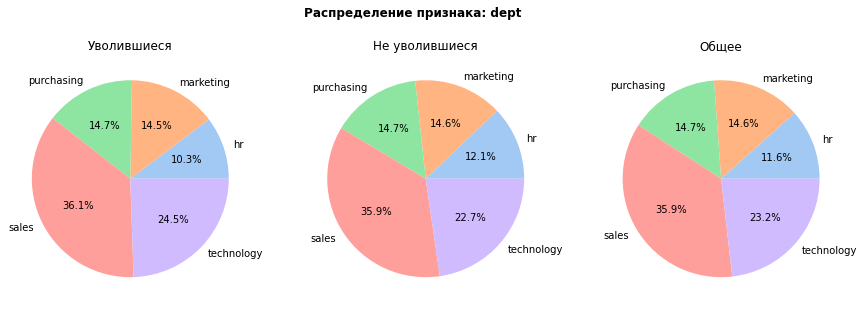

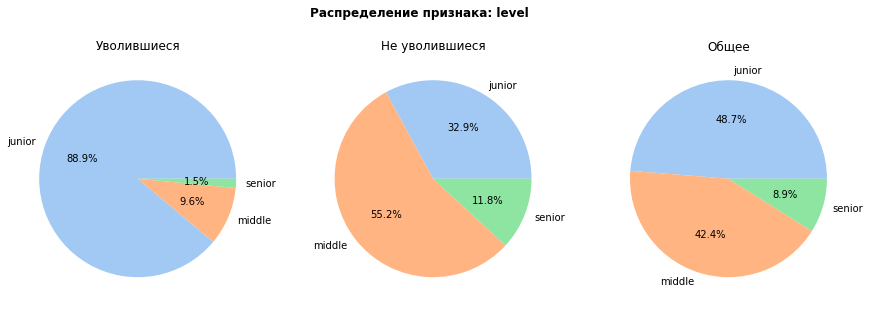

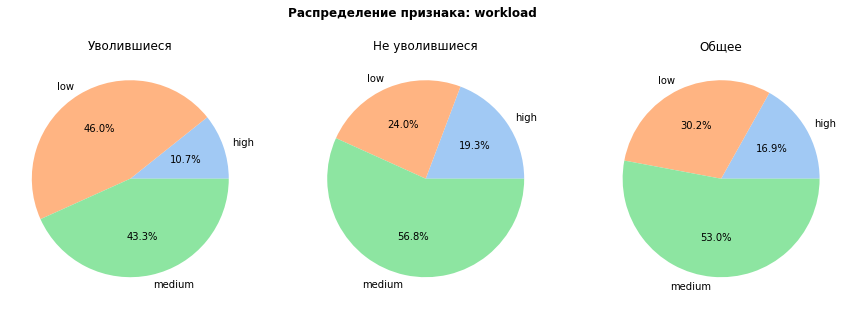

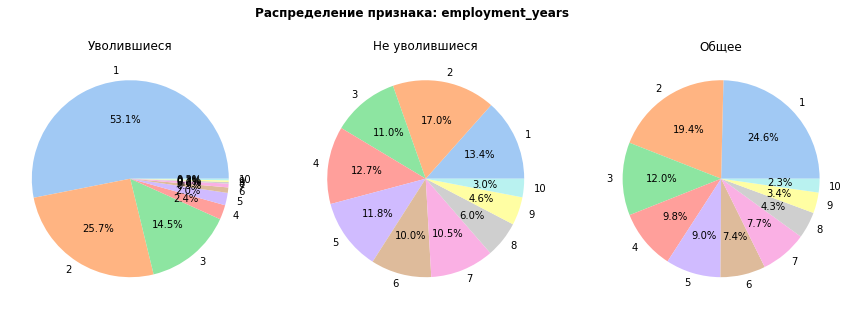

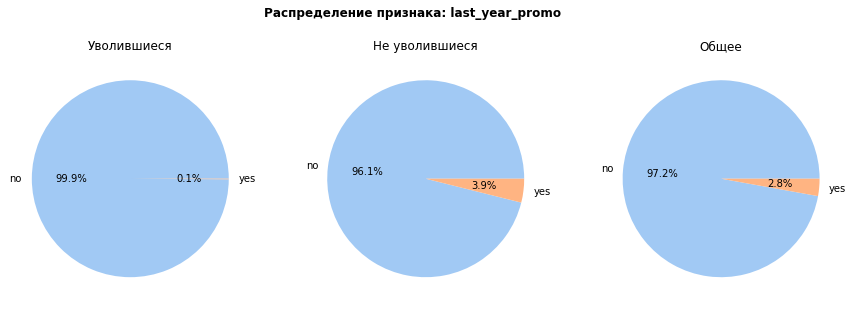

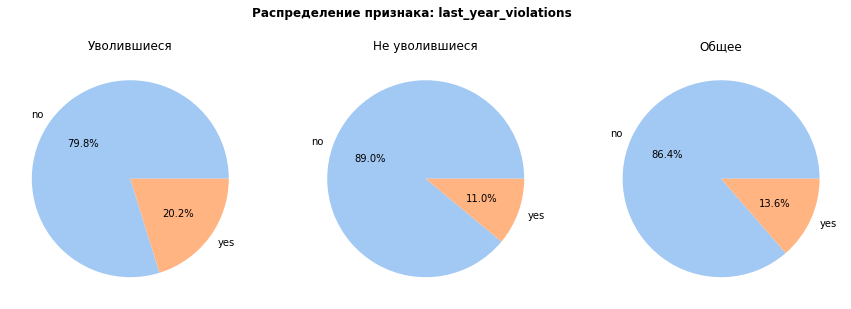

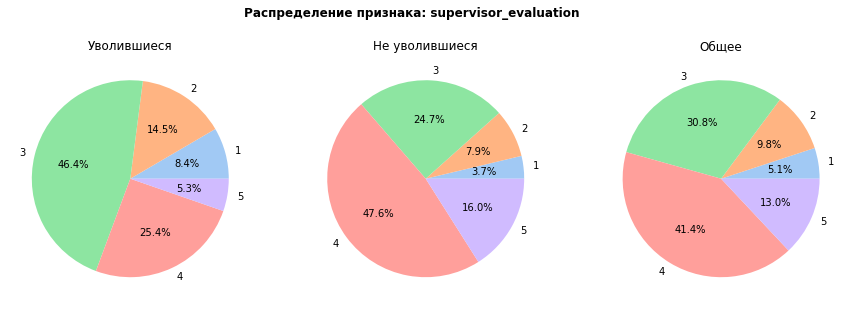

In [95]:
titles_for_pie = ['Уволившиеся', 'Не уволившиеся', 'Общее']
for i in X_train_quit.drop(['id', 'salary', 'quit'], axis=1):
    compare_pie_3(X_train_quit.query('quit=="yes"'),  X_train_quit.query('quit=="no"'), X_train_quit, i)

**Среди уволившихся сотрудников (левая колонка):**
* 89% junior (при общей доле таких сотрудников в компании - 49%)
* 46% низкая нагрузка (при общей доле таких сотрудников в компании - 30%)
* 99.9% случаев не повышались за прошедший год
* В 2 раза чаще нарушали трудовой договор, чем оставшиеся.
* Почти в 70% случаев имели оценку руководителя 3 и ниже (при общей доли таких сотрудников в компании - 45%)
* В 79% случаев работали 1-2 года (при общей доли таких сотрудников в компании - 44%)

Количество увольнений в разных отделах - примерно в равных пропорциях.

Также построим графики countplot и histplot, чтобы 
* Оценить соотношение уволившихся/не уволившихся сотрудников при разных значениях признаков, 
* Определить сотрудников, для которых вероятность увольнения которых - более 50%:

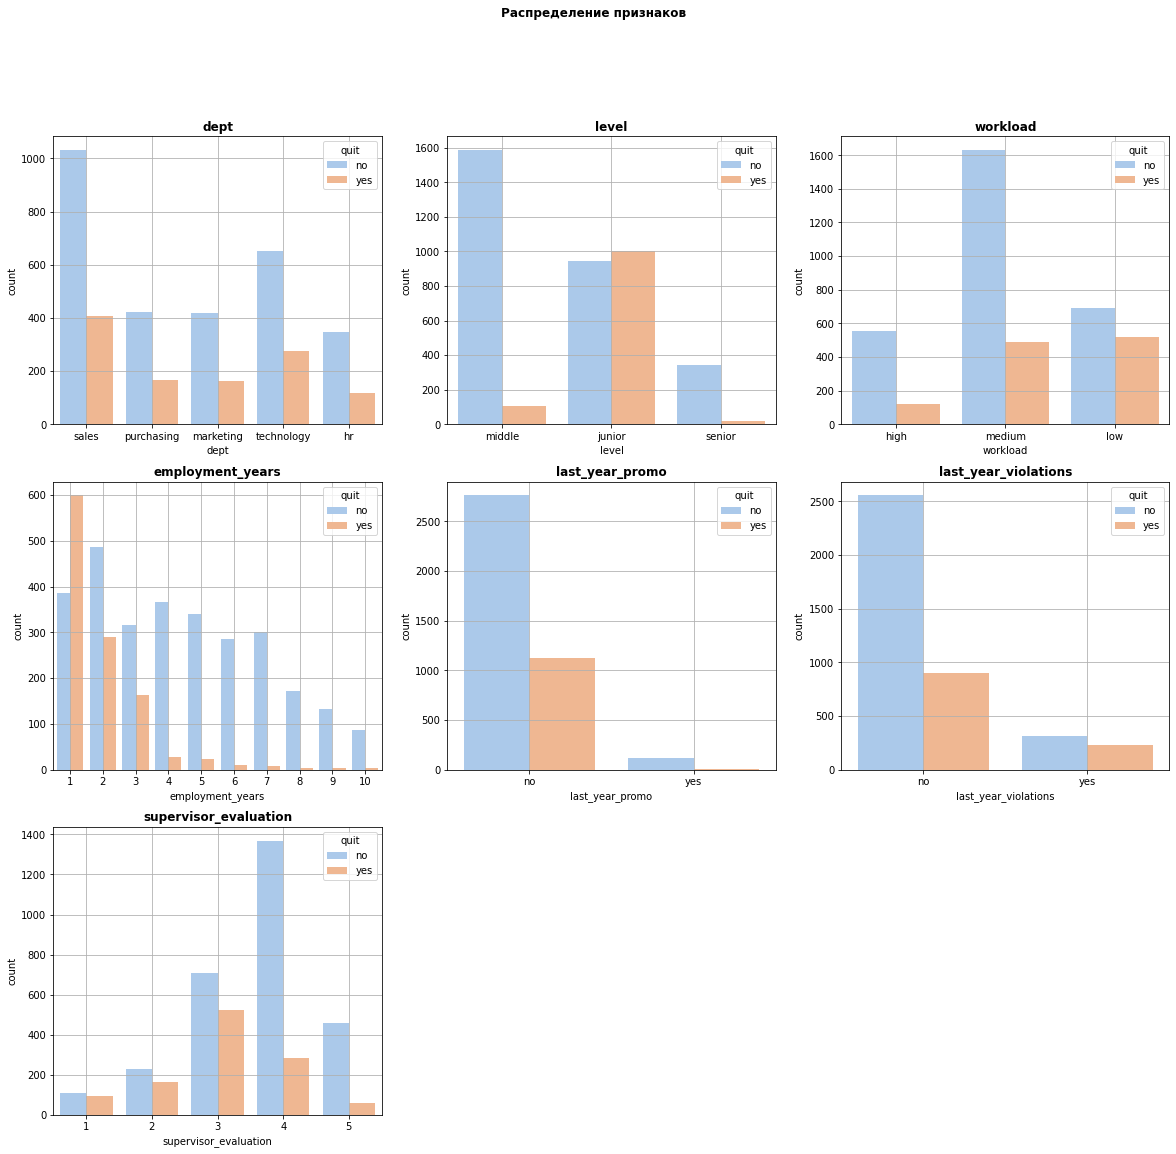

зарплата:


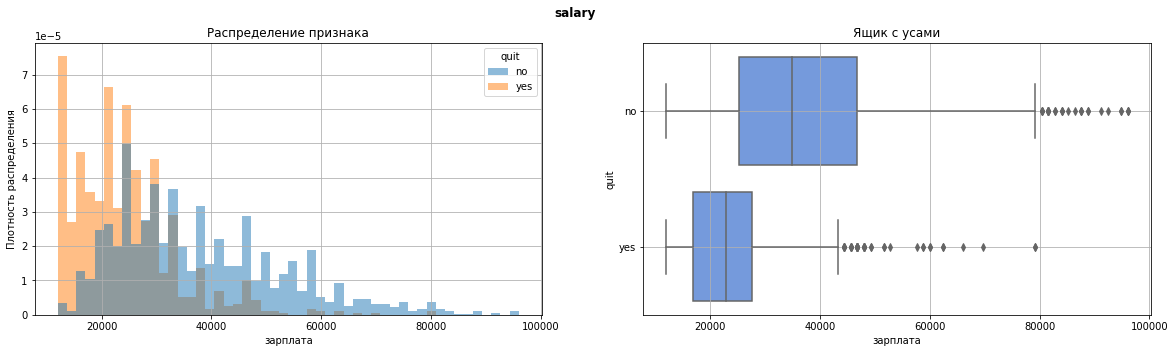


  Средняя зарплата:
37702.23  - не уволившиеся
23885.11  - уволившиеся

Средняя зарплата не уволившихся сотрудников выше на   13817.12


In [96]:
p=1
plt.figure(figsize=(20, 18))
for y in X_train_quit.drop(['id', 'salary', 'quit'], axis=1).columns:
    plt.subplot(3, 3, p)
    plt.suptitle('Распределение признаков', fontweight='bold')
    sns.countplot(x=y, data=X_train_quit, hue='quit', palette='pastel')
    plt.title(y, fontweight='bold')
    plt.grid()
    p +=1
plt.show()

print ('зарплата:')
make_hist_density(X_train_quit, 'salary', 50, 'quit', 'зарплата')

print('\n  Средняя зарплата:')
print(round(X_train_quit.query('quit=="no"')['salary'].mean(), 2), ' - не уволившиеся')
print(round(X_train_quit.query('quit=="yes"')['salary'].mean(), 2), ' - уволившиеся')


print('\nСредняя зарплата не уволившихся сотрудников выше на  ', round(
    X_train_quit.query('quit=="no"')['salary'].mean() - X_train_quit.query('quit=="yes"')['salary'].mean(), 2)
     )


Высокую долю увольнения наблюдаем у сотрудников, у которых:
* низкий уровень нагрузки 
* работает меньше 4 лет
* не повышался в последний год
* нарушал трудовой договор в течение года
* оценка руководителя - 3 и ниже
* зарплата ниже 30000

Сотрудников, для которых **вероятность увольнения выше 50%**, определим по значениям признаков, которые чаще встречаются у уволившихся сотрудников.    
Это:
* зарплата ниже 19000
* длительность работы 1 год
* уровень junior


Зарплаты уволившихся сотрудников в среднем на 13817.12 ниже, чем у не уволившихся.

**Вывод:**

Чаще увольнения встречаются среди следующих сотрудников:
* низкий уровень нагрузки 
* работает меньше 4 лет
* не повышался в последний год
* нарушал трудовой договор в течение года
* оценка руководителя - 3 и ниже
* зарплата ниже 30000
* уровень junior

Вероятность увольнения выше 50% для сотрудников, у которых:
* зарплата ниже 19000
* длительность работы 1 год
* уровень junior

#### Влияние уровня удовлетворённости сотрудника на, увольнение

Объединим данные из X_test_quit с y_test_sat и y_test_quit:

In [97]:
sat_rate_influence = X_test_quit.copy()
sat_rate_influence = sat_rate_influence.merge(y_test_sat, on='id')
sat_rate_influence = sat_rate_influence.merge(y_test_quit, on='id')
sat_rate_influence.head(3)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.72,no
2,467458,sales,middle,low,5,no,no,4,19200,0.64,no


Уровень корреляции между признаками:

In [98]:
interval_cols = ['salary', 'job_satisfaction_rate']

sat_rate_influence[['job_satisfaction_rate', 'quit']].phik_matrix(interval_cols=interval_cols)

,job_satisfaction_rate,quit
job_satisfaction_rate,1.000000,0.610263
quit,0.610263,1.000000


* Корреляция есть, средняя, 0.61

Оценим визуально через scatterplot:

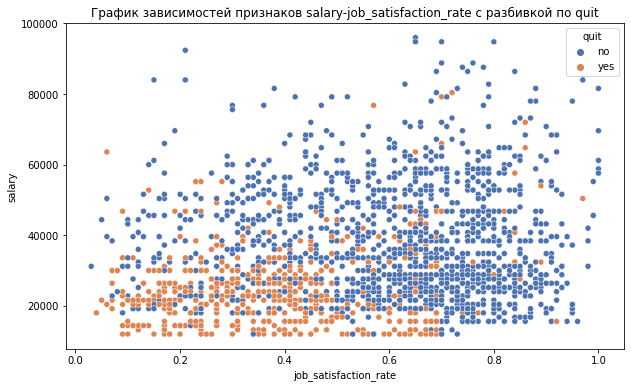

In [99]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data = sat_rate_influence, x='job_satisfaction_rate', y='salary', hue='quit', palette='deep')
plt.title('График зависимостей признаков salary-job_satisfaction_rate с разбивкой по quit')
plt.show()

* чаще встречается уволившиеся сотрудники при низких значениях удовлетворенности, менее 0.5.

Сотрудники с уровнем удовлетворенности выше 0.7 увольняются крайне редко.

Построим гистаграмму и ящик с усами, выведем описательную статистику:

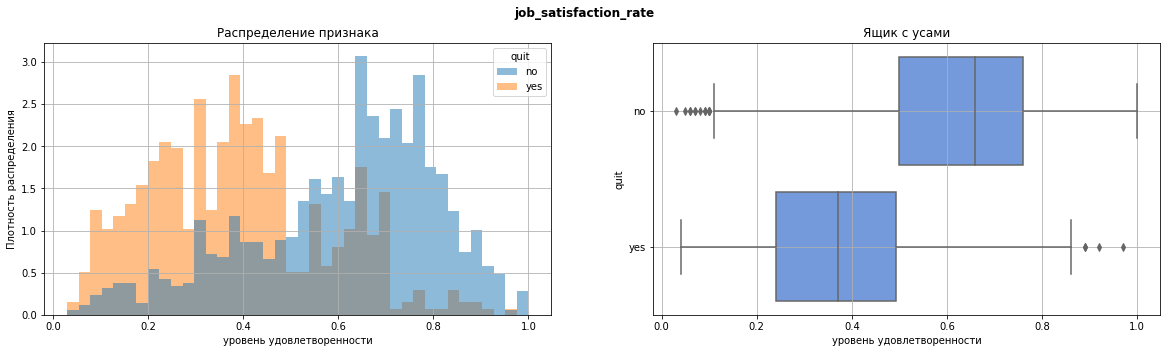

Уволившиеся:


,count,mean,std,min,25%,50%,75%,max
job_satisfaction_rate,564.0,0.387713,0.185784,0.04,0.24,0.37,0.4925,0.97


Не уволившиеся:


,count,mean,std,min,25%,50%,75%,max
job_satisfaction_rate,1436.0,0.61204,0.199367,0.03,0.5,0.66,0.76,1.0


In [100]:
make_hist_density(sat_rate_influence, 'job_satisfaction_rate', 40, 'quit', 'уровень удовлетворенности')

print ('Уволившиеся:')
display(pd.DataFrame(sat_rate_influence.query('quit=="yes"')['job_satisfaction_rate'].describe()).T)

print ('Не уволившиеся:')
pd.DataFrame(sat_rate_influence.query('quit=="no"')['job_satisfaction_rate'].describe()).T

Для уволившихся сотрудников среднее значение удовлетворенности заметно ниже:
* 0.39 против 0.61

В 75% случаев уровень удовлетворенности уволившегося сотрудника:
* менее 0.5

В 75% случаев уровень удовлетворенности уволившегося сотрудника:
* более 0.5



Можно заключить, что корреляция между этими признаками действительно присутствует.  
Чем выше уровень удовлетворенности сотрудника, тем ниже риск его увольнения.

#### **Вывод по 2.3 разделу**

Распределение входных признаков соответствует распределению в 1.3.

**Целевой признак:**
* Доля уволившихся сотрудников в датасете - 28%

**Портрет уволившегося сотрудника:**  

Чаще увольнения встречаются среди следующих сотрудников:
* низкий уровень нагрузки 
* работает меньше 4 лет
* не повышался в последний год
* нарушал трудовой договор в течение года
* оценка руководителя - 3 и ниже
* зарплата ниже 30000
* уровень junior

**Вероятность увольнения выше 50%:**  
для сотрудников, у которых:
* зарплата ниже 19000
* длительность работы 1 год
* уровень junior

**Влияние уровня удовлетворённости сотрудника на увольнение:**
* Корреляция = 0.61

Для уволившихся сотрудников среднее значение удовлетворенности заметно ниже:
* 0.39 против 0.61

В 75% случаев уровень удовлетворенности уволившегося сотрудника:
* менее 0.5

В 75% случаев уровень удовлетворенности уволившегося сотрудника:
* более 0.5

### **Добавление нового входного признака**

Возьмем лучшую модель из п.1.6 и применим её с целью получить уровени удовлетворенности для новых датасетов.

Предскажем значения удовлетворенности для тренировочных данных, предварительно убрав незнакомые для модели признаки:
* `quit`
* `id` - сделаем из него индекс

In [101]:
X_train_quit['job_satisfaction_rate'] = grid_search.best_estimator_.predict(
    X_train_quit.drop('quit', axis=1).set_index('id'))

X_train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.635385
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.815938
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.364091
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.380000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000


То же для тестовых данных:

In [102]:
X_test_quit['job_satisfaction_rate'] = grid_search.best_estimator_.predict(
    X_test_quit.set_index('id'))

X_test_quit.head(3)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.872000
1,686555,hr,junior,medium,1,no,no,4,30000,0.668621
2,467458,sales,middle,low,5,no,no,4,19200,0.657143


Данные объединены успешно.

#### **Вывод по 2.4 разделу**

Предсказания удовлетворенности для новых выборок получены.

В дальнейшем сможем применить эти значения при обучении модели для решения задачи классификации.

### **Подготовка данных**

Столбец `id` уберем в индекс:

In [103]:
X_train_quit = X_train_quit.set_index('id')

# Отсортируем тестовые данные по id, чтобы в дальнейшем не запутаться при сравнении предсказанных значений с истинными
X_test_quit = X_test_quit.sort_values(by='id').set_index('id')
y_test_quit = y_test_quit.sort_values(by='id').set_index('id')

**Разделим выборки на входные признаки и таргет:**

train:

In [104]:
X_train_clf = X_train_quit.drop('quit', axis=1)
y_train_clf = X_train_quit['quit']

print ('X_train_clf, shape=', X_train_clf.shape)
display(X_train_clf.head(3))
print ('y_train_clf, shape=', y_train_clf.shape)
display(y_train_clf.head(3))

X_train_clf, shape= (4000, 9)


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0.635385
814010,sales,junior,medium,2,no,no,4,27600,0.815938
155091,purchasing,middle,medium,5,no,no,1,37200,0.364091


y_train_clf, shape= (4000,)


id
723290    no
814010    no
155091    no
Name: quit, dtype: object

Тестовые уже готовы, просто сделаем копии:

In [105]:
X_test_clf = X_test_quit.copy()
y_test_clf = y_test_quit.copy()
y_test_clf = y_test_clf['quit']

print ('X_test_clf, shape=', X_test_clf.shape)
display(X_test_clf.head(3))
print ('y_test_clf, shape=', y_test_clf.shape)
display(y_test_clf.head(3))

X_test_clf, shape= (2000, 9)


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.835185
100480,marketing,junior,low,4,no,no,4,16800,0.850000
100503,purchasing,middle,high,5,no,no,4,55200,0.738000


y_test_clf, shape= (2000,)


id
100298    no
100480    no
100503    no
Name: quit, dtype: object

Изменим списки с названиями признаков, т.к. у нас появился новый - `job_satisfaction_rate`:

In [106]:
# Добавляем в список num_cols
num_columns.append('job_satisfaction_rate')

print ('ohe_columns:\n', ohe_columns)
print ('\nord_columns:\n', ord_columns)
print ('\nnum_columns:\n', num_columns)

ohe_columns:
 ['dept', 'last_year_promo', 'last_year_violations']

ord_columns:
 ['level', 'workload']

num_columns:
 ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


**Кодирование целевого признака:**

Через LabelEncoder.

Определим категорию "no" как 0, "yes" - как 1.

In [107]:
original_classes = ['no', 'yes']

le_custom = LabelEncoder()
le_custom.classes = np.array(original_classes)   
le_custom.classes

array(['no', 'yes'], dtype='<U3')

Кодируем:

In [108]:
y_train_clf = le_custom.fit_transform(y_train_clf)
y_test_clf = le_custom.transform(y_test_clf)

Пайплайн для новой задачи обновим:

In [109]:
pipe_final_clf = Pipeline([
    ('preprocessor', data_preprocessor), 
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

#### Вывод

Подготовка данных проведена.

Данные разбиты на X_train_clf, X_test_clf, y_train_clf, y_test_clf.

Добавлен новый признак `job_satisfaction_rate` в список с названиями признаков - в num_columns.

Целевой признак закодирован с помощью LabelEncoder:
* "no" = 0
* "yes" = 1

Обновлен пайплайн для задачи классиикации:
* 'models', LogisticRegression(random_state=RANDOM_STATE)

### **Обучение модели - 1**

Задаем модели и их гиперпараметры для перебора:

In [110]:
param_grid_clf = [
    # словарь для модели DecisionTreeClassifier()
    ## макс. глубина и количество функций
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,20),
        'models__max_features': range(2,20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # для KNeighborsClassifier() 
    ## количество ближайших соседей
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,50),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # для LogisticRegression()
    ## лассо-регуляризация, перебор значения силы регуляризации
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,30),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }, 
    
    # для SVC()
    ## с линейным и нелинейным ядром
    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            probability=True
        )],
        'models__kernel': ['rbf', 'linear'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    }
]

**Запуск автоматического перебора через RandomizedSearch:**

In [111]:
randomized_search = RandomizedSearchCV(
    pipe_final_clf, 
    param_grid_clf, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train_clf, y_train_clf)

# Выведем на экран параметры лучшей модели и значение метрики
print ('\n3 лучшие модели и их значения метрики:')
display(pd.DataFrame(randomized_search.cv_results_).sort_values(by='mean_test_score', ascending=False).head(3))

print ('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели при кросс-валидации:', round(randomized_search.best_score_, 3))


3 лучшие модели и их значения метрики:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__C,param_models,param_models__max_features,param_models__max_depth,param_models__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.034205,0.003607,0.044010,0.004386,StandardScaler(),NaN,KNeighborsClassifier(),NaN,NaN,26.0,"{'preprocessor__num': StandardScaler(), 'model...",0.921113,0.917411,0.923310,0.929963,0.943160,0.926991,0.009057,1
3,0.062688,0.046328,0.051938,0.008479,StandardScaler(),NaN,KNeighborsClassifier(),NaN,NaN,43.0,"{'preprocessor__num': StandardScaler(), 'model...",0.924986,0.914682,0.925985,0.929473,0.936561,0.926338,0.007102,2
2,0.158607,0.049954,0.022955,0.013350,passthrough,5.0,"LogisticRegression(penalty='l1', random_state=...",NaN,NaN,NaN,"{'preprocessor__num': 'passthrough', 'models__...",0.924008,0.910508,0.914634,0.910229,0.926910,0.917258,0.006937,3


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('SimpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

**Результат при кросс-валидации:**

Лучшая модель:

* KNeighborsClassifier
* n_neighbors=26
* Скейлер - StandardScaler()

Значение roc_auc:
* 0.927

Достаточно хороший результат.

В тройку лучших моделей также вошли:
* KNeighborsClassifier(n_neighbors=26), StandardScaler()
* LogisticRegression(penalty='l1', C=10), MinMaxScaler()

#### Вывод

Лучшая модель:

* KNeighborsClassifier
* n_neighbors=26
* Скейлер - StandardScaler()

Значение roc_auc при кросс-валидации:
* 0.927

Модель работает достаточно хорошо, сбалансирована - успешно классифицирует объекты как первого, так и второго классов.

Далее проведем анализ важности признаков и подумаем, можно ли улучшить модель.

### **Анализ важности признаков**

Интерпретируем модель методом оценки важности признаков SHAP

1. Преобразуем данные

In [112]:
# Закодируем и масштабируем X_train через preprocessor:
X_train_transformed = randomized_search.best_estimator_.named_steps['preprocessor'].fit_transform(X_train_clf)
X_test_transformed = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_test_clf)

# Возьмем названия столбцов через get_feature_names_out из ohe_pipe и ord_pipe:
feature_names = randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

# Создаем DataFrame
X_train_transformed = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names)
X_test_transformed.head(2)

,ohe__dept_marketing,ohe__dept_purchasing,ohe__dept_sales,ohe__dept_technology,ohe__last_year_promo_yes,ohe__last_year_violations_yes,ord__level,ord__workload,num__employment_years,num__supervisor_evaluation,num__salary,num__job_satisfaction_rate
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.669477,0.523197,-0.964046,1.361983
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.117449,0.523197,-1.122456,1.429805


2. Создадим семплы, 25 шт:

In [113]:
X_train_transformed_sample = shap.sample(X_train_transformed, 25, random_state=RANDOM_STATE)
X_test_transformed_sample = shap.sample(X_test_transformed, 25, random_state=RANDOM_STATE)

3. Оценим общую важность признаков модели по значениям Шепли::

In [114]:
explainer = shap.KernelExplainer(
    randomized_search.best_estimator_.named_steps['models'].predict_proba, X_train_transformed_sample)

shap_values = explainer(X_train_transformed_sample)


  0%|          | 0/25 [00:00<?, ?it/s]

None

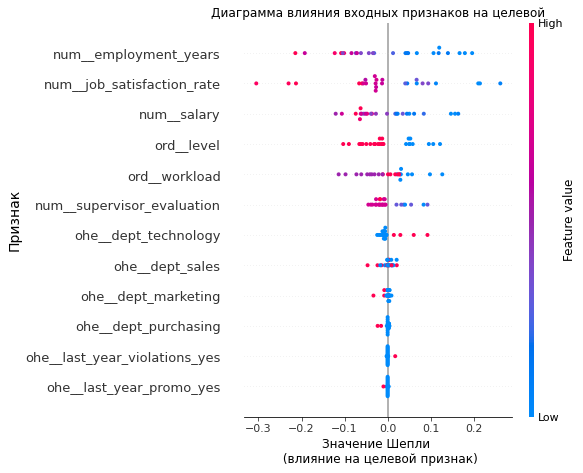

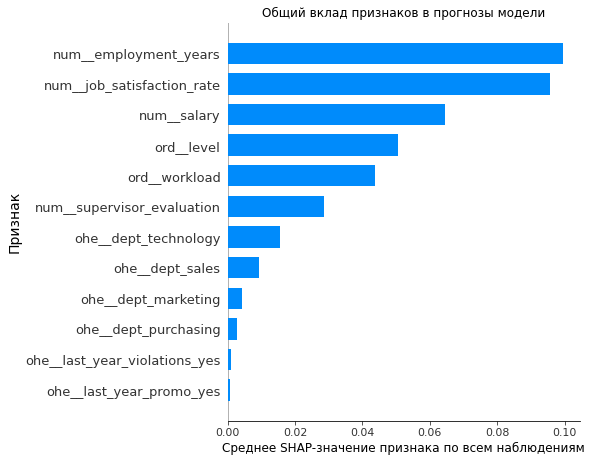

In [115]:
display(
    shap.summary_plot(shap_values[...,1], X_train_transformed_sample, 
                      feature_names=feature_names, max_display=15, show=False)
       )
fig, ax = plt.gcf(), plt.gca()
ax.set_ylabel('Признак', fontsize=14)
ax.set_xlabel('Значение Шепли \n (влияние на целевой признак)', fontsize=12)
ax.set_title('Диаграмма влияния входных признаков на целевой', fontsize=12)
plt.show()

shap.summary_plot(shap_values[...,1], X_train_transformed_sample, 
                  plot_type="bar", feature_names=feature_names, max_display=15, show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_ylabel('Признак', fontsize=14)
ax.set_xlabel('Среднее SHAP-значение признака по всем наблюдениям', fontsize=12)
ax.set_title('Общий вклад признаков в прогнозы модели', fontsize=12)
plt.show()

#### Вывод

Наиболее значимые признаки с точки зрения модели:
* `employment_years` - чем меньше, тем выше вероятность увольнения
* `job_satisfaction_rate` - чем меньше, тем выше вероятность увольнения
* `salary` - чем ниже, тем выше вероятность увольнения
* `level` - чем ниже, тем выше вероятность увольнения
* `workload` - чем ниже, тем выше вероятность увольнения
  * средний уровень занятости - самая низкая вероятность увольнения

Интересно, что сотрудники отдела `technology` оказались в модели более склонными к увольнению, чем сотрудники остальных отделов. 

Наименее значимые признаки с точки зрения модели:
* `last_year_promo`
* `last_year_violations`
* `dept`  
В целом, это кажется закономерным. В исследовательском анализе ранее выявили, что в разных отделах увольняется примерно одинаковый процент сотрудников. А повышения и нарушения трудового договора встречаются довольно редко.

### **Новая модель - обучение**

Уберем наименее значимые с точки зрения модели признаки и посмотрим, как изменится результат.

**Подготовка данных**

Удалим столбцы, которая модель посчитала наименее значимыми:

In [116]:
X_train_clf_2 = X_train_clf.drop(['last_year_promo', 'last_year_violations', 'dept'], axis=1)
X_test_clf_2 = X_test_clf.drop(['last_year_promo', 'last_year_violations', 'dept'], axis=1)

Поскольку после удалений столбцов у нас не осталось тех, которые обрабатываем через OneHotEncoder,
* обновим пайплайн, удалив этап 'ohe' из data_preprocessor:

In [117]:
data_preprocessor = ColumnTransformer([
    ('ord', ord_pipe, ord_columns), 
    ('num', StandardScaler(), num_columns)
], 
    remainder='passthrough'
)

pipe_final_clf_2 = Pipeline(
    [
        ('preprocessor', data_preprocessor), 
        ('models', LogisticRegression(random_state=RANDOM_STATE))
    ]
)

**Запуск автоматического перебора гиперпараметров через RandomizedSearch:**

In [118]:
randomized_search2 = RandomizedSearchCV(
    pipe_final_clf_2, 
    param_grid_clf, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search2.fit(X_train_clf_2, y_train_clf)

# Выведем на экран параметры лучшей модели и значение метрики
print ('\n3 лучшие модели и их значения метрики:')
display(pd.DataFrame(randomized_search2.cv_results_).sort_values(by='mean_test_score', ascending=False).head(3))

print ('Лучшая модель и её параметры:\n\n', randomized_search2.best_estimator_)
print ('Метрика лучшей модели на кросс-валидационной выборке:', randomized_search2.best_score_)


3 лучшие модели и их значения метрики:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__C,param_models,param_models__max_features,param_models__max_depth,param_models__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.019735,0.001926,0.024241,0.002591,StandardScaler(),NaN,KNeighborsClassifier(),NaN,NaN,26.0,"{'preprocessor__num': StandardScaler(), 'model...",0.934153,0.933774,0.926906,0.931724,0.952276,0.935767,0.008648,1
3,0.019197,0.000674,0.030458,0.003421,StandardScaler(),NaN,KNeighborsClassifier(),NaN,NaN,43.0,"{'preprocessor__num': StandardScaler(), 'model...",0.927687,0.932591,0.923788,0.932904,0.947473,0.932889,0.008033,2
5,0.022341,0.003515,0.013894,0.003723,MinMaxScaler(),NaN,DecisionTreeClassifier(random_state=42),6.0,4.0,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.917828,0.906528,0.928429,0.918250,0.923380,0.918883,0.007287,3


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'senior'],
                                                                                              ['low',
                                                                                               'medium',
                 

**Результат на кросс-валидационной выборке:**

Лучшая модель осталась та же:
* KNeighborsClassifier
* n_neighbors=26
* Скейлер - StandardScaler()

Значение roc_auc при кросс-валидации:
* 0.936

Очень хороший результат.

Улучшили значение метрики при кросс-валидации.


В тройку лучших моделей вошли только модели KNeighborsClassifier:
* KNeighborsClassifier(n_neighbors=43), StandardScaler()	
* KNeighborsClassifier(n_neighbors=53), MinMaxScaler()

Проверим значение метрики на тестовой выборке:

Метрика ROC-AUC на тестовой выборке:  0.921


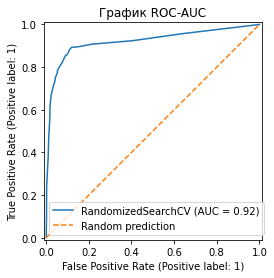

In [119]:
# Предсказываем вероятности для подсчета метрики
y_test_clf_proba_2 = randomized_search2.predict_proba(X_test_clf_2)
print('Метрика ROC-AUC на тестовой выборке: ', round(
    roc_auc_score(y_test_clf, y_test_clf_proba_2[:,1]), 3))

# Построим ROC-кривую для визуализации результата
RocCurveDisplay.from_estimator(randomized_search2, X_test_clf_2, y_test_clf)
plt.plot([0,1], [0,1], linestyle='dashed', label='Random prediction')
plt.title('График ROC-AUC')
plt.legend()
plt.show()

**Результат, test:**

ROC-AUC тестовой выборки также высоко 0.921.

На ROC-кривой видно, что даже при FPR около 0.9 имеем очень высокое значение TPR - 0.9.

Модель качественно определяет оба класса.

Видим резкое изменение графика - это хорошо. 

Проверка на адекватность:

Метрика ROC-AUC при DummyClassifier, strategy="prior":  0.5


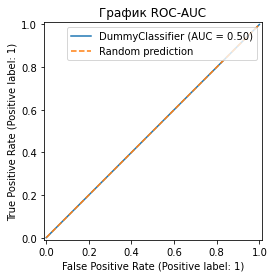

In [120]:
dummy_clf = DummyClassifier(strategy="prior", random_state=RANDOM_STATE)
dummy_clf.fit(X_train_clf_2, y_train_clf)
y_clf_proba_dummy = dummy_clf.predict_proba(X_test_clf_2)

print('Метрика ROC-AUC при DummyClassifier, strategy="prior": ', round(
    roc_auc_score(y_test_clf, y_clf_proba_dummy[:,1]), 3))

# Построим ROC-кривую для визуализации результата
RocCurveDisplay.from_estimator(dummy_clf, X_test_clf_2, y_test_clf)
plt.plot([0,1], [0,1], linestyle='dashed', label='Random prediction')
plt.title('График ROC-AUC')
plt.legend()
plt.show()

* Всего 0.5. Собственно, и на графике совпадает с прямой Random Prediction.

Очевидно, полученная модель проделывает качественную работу по классификации целевого признака.  
Случайным образом получить значения метрики ROC-AUC 0.921 для тестовых данных не получится.

Этапы работы проекта принесли свои плоды.

#### Вывод

После удаления признаков, которые модель посчитала наименее значимыми, удалось немного улучшить значение ROC-AUC кросс-валидации:
* 0.936

На тестовых данных модель тоже показала хороший результат:
* 0.921

При этом лучшей осталась модель KNeighborsClassifier с гиперпараметром:
* n_neighbors=26 (число ближайших соседей)
* Скейлер - StandardScaler()

Модель получилась качественной и сбалансированной, определяет хорошо оба класса:
* На ROC-кривой видно, что даже при FPR около 0.9 имеем очень высокое значение TPR - 0.9.

При правильно подобранном количестве ближайших соседей KNN отличается довольно высокой точностью прогнозов. Поскольку в гиперпараметрах мы перебрали от 2 до 50 ближайших соседей, удалось найти наиболее оптимальный вариант, который показал лучшие результаты метрики. При достаточно большой тренировочной выборке мы имели довольно большое количество объектов, чтобы даже при небольшом количестве ближайших соседей все они находились относительно близко друг к другу.

## **Общий вывод**

#### Описание задачи


Для  компании «Работа с заботой» необходимо было построить 2 модели:
1. Предсказание уровеня удовлетворённости сотрудника работой в компании от 0 до 1, где:
 * 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.
2. Предсказание увольнения сотрудника, классификация:
 * Уволится или не уволится

#### Этапы работы:


**Часть 1 - Предсказание уровня удовлетворенности**

1. **Загрузка данных**

Тренировочная выборка: 4000 строк, 9 столбцов с признаками  
Тестовая выборка без таргета: 2000 строк, 8 столбцов с признаками  
Значения целевых признаков для тестовой выборки таргет: 2000 строк, 2 столбца  

Целевой признак - `job_satisfaction_rate

2. **Предобработка данных**

Модой заполнены пропуски в столбцах `dept`, `level` и `workload` с помощью пайплайна;  
Исправлены опечатки "sinior" на "senior";  
Убедились, что все значения `job_satisfaction_rate` входят в промежуток [0, 1]
Проверена корректность выборок:
* списки `id` полностью совпадают в тестовых выборках и не пересекаются с тренировочной

3. **Исследовательский анализ данных**

Значения всех признаков, в том числе целевого, распределены в датасетах в одинаковых пропорциях.

*dept:*
* 38% из отдела продаж - sales, 22% из technology, 13-15% из marketing и purchasing, 11.3% hr - наименьшее количество

*level:*
* 43% middle и 48% junior, Senior - всего  8.6 - 9%

*workload:*
* Половина работников - medium, 1/3 - low, менее 20% - high

*employment_years:*  

45% сотрудников имеют стаж не более 2 лет.   
Однако, если разбить этот признак по занимаемым должностям, картина получается следующая:   
* Junior: 75% работают 1-2 года, max - 5 
* Middle: в 50% случаев работают от 3 до 7 лет, max - 10 лет
* Senior: в 50% случаев работают от 4 до 8 лет, max - 10 лет

*last_year_promo:*
* 5% сотрудников уровня middle повышены в последний год, 8.5% - senior

*last_year_violations:*
* 13-14% сотрудников нарушали трудовой договор
* Чаще производят те, кто имеет низкий уровень удовлетворённости работой в компании
  * в 39% случаев при уровне удовлетворенности работой менее 0.3

*supervisor_evaluation:*
* 70% оценок - 3 или 4, 14% - 5, 14% - ниже 3
* Сотрудникам, низко оценившим удовлетворенность работой в компании, соответствуют более низкие оценки качества работы от руководителя
* Сотрудники, оценившие удовлетворенность компанией выше 0.7, редко получают оценку качества работы ниже 4.

*salary:*
* Медианная - 30000, Средняя - 33926, Размах - от 12000 до 98400, 75% сотрудников имеют зарплату ниже 43200

*job_satisfaction_rate, целевой признак:*
* Среднее - 0.53, Медианное - 0.56
* Половина сотрудников поставила оценки от 0.36 до 0.71
* Распределение в целом равномерное, хотя есть два небольших пика в районе 0.4 и 0.7

Сотрудники, более низко оценившие удовлетворенность работой:
* незначительно реже получали повышение, чаще нарушали трудовой договор, получали более низкие оценки работы от руководителей


4. **Корреляционный анализ**

Входные признаки, наиболее коррелирующие с целевым:
* 0.764 - supervisor_evaluation
* 0.56 - last_year_violations

Средняя/слабая корреляция:
* 0.326 - employment_years

Мультиколлинеарность между входными признаками не наблюдается.

5. **Подготовка признаков** 

Разделили данные в выборках на входные признаки и таргет для тренировочной и тестовой выборок.

Признаки определены в следующие столбцы:
* ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
* ord_columns = ['level', 'workload']
* num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

Вошедший в финальный пайплайн data_preprocessor состоит, соответственно из этапов ohe_pipe, ord_pipe, и StandardScaler() для признаков из num_columns

6. **Обучение модели**

Цель:
* Получить SMAP < 15 на тестовой выборке

SMAPE - симметричное среднее абсолютное процентное отклонение
* Среднее значение отношения модуля разницы фактического и предсказанного значений к половине суммы модулей фактического и предсказанного значений, умноженное на 100.

Поиск лучшей модели осуществлен через перебор гиперпараметров:
* Модель LinearRegression():
  * Скейлеры: StandardScaler(), MinMaxScaler()
* Модель DecisionTreeClassifier():
  * 'models__max_depth': от 3 до 15
  * 'models__max_features': от 3 до 15
  * Скейлеры: StandardScaler(), MinMaxScaler()

Перебор гиперпараметров осуществлялся через GridSearchCV.

**Результат:**

Лучшая модель:
* DecisionTreeRegressor
* param_models__max_features = 11
* param_models__max_depth = 13
* MinMaxScaler

Итог работы по метрике SMAP на кросс-валидационной выборке:
* 15.01

Итог работы по метрике SMAP на тестовых данных:
* 14.28

Анализ остатков:
* Остатки нормально распределены.  
* Среднее практически равно нулю.  
* Стандартное отклонение - 0.08. Т.е. не более 10%.  

* В 50% случаев отклонение не более 0.1.

* Макс. отклонения: -0.32; 0.46

**Почему эта модель оказалась лучшей:**
* для дерева решений перебирались гиперпараметры, поэтому её удалось лучше настроить и найти наилучшее решение. 



**Часть 2 - Предсказание увольняющихся сотрудников**


1. **Загрузка данных**

Входящие данные новой тестовой выборки полностью совпадают со старой тестовой выборкой.  
Датасет с тренировочными данными X_train_quit имеет такое же признаковое описание, как и в X_train_sat, но другие `id`        
  Целевой признак - `quit`(yes/no) 


2. **Предобработка данных**

Исправлены опечатки 'sinior' - 'senior'.  
Заполнены пропуски - заменены на наиболее популярное значение с помощью пайплайна.   
Явных дубликатов не обнаружено.

3. **Исследовательский анализ данных**

Распределение входных признаков соответствует распределению в 1.3.

*Целевой признак:*
* Доля уволившихся сотрудников в датасете - 28%

*Портрет уволившегося сотрудника:*  

Чаще увольнения встречаются среди следующих сотрудников:
* низкий уровень нагрузки 
* работает меньше 4 лет
* не повышался в последний год
* нарушал трудовой договор в течение года
* оценка руководителя - 3 и ниже
* зарплата ниже 30000
* уровень junior

*Вероятность увольнения выше 50%:*  
для сотрудников, у которых:
* зарплата ниже 19000
* длительность работы 1 год
* уровень junior

*Влияние уровня удовлетворённости сотрудника на увольнение:*
* Корреляция = 0.61

Для уволившихся сотрудников среднее значение удовлетворенности заметно ниже:
* 0.39 против 0.61

В 75% случаев уровень удовлетворенности уволившегося сотрудника:
* менее 0.5

В 75% случаев уровень удовлетворенности уволившегося сотрудника:
* более 0.5

4. **Добавление нового входного признака**

С помощью лучшей модели из Части 1 спрогнозировали уровни удовлетворенности сотрудников из новых выборок и добавили их туда.

5. **Подготовка данных**

Данные разбиты на X_train_clf, X_test_clf, y_train_clf, y_test_clf.

Добавлен новый признак `job_satisfaction_rate` в список с названиями признаков - в num_columns.

Целевой признак закодирован с помощью LabelEncoder:
* "no" = 0
* "yes" = 1

Обновлен пайплайн для задачи классиикации:
* 'models', LogisticRegression(random_state=RANDOM_STATE)

6. **Первая модель**

Лучшая модель:

* KNeighborsClassifier
* n_neighbors=26
* Скейлер - StandardScaler()

Значение roc_auc:
* 0.927 - кросс-валидация

**Детали:**
Получена перебором гиперпараметров:
* DecisionTreeClassifier:
  * 'models__max_depth': range(2,20),
  * 'models__max_features': range(2,20),
* KNeighborsClassifier:
  * 'models__n_neighbors': range(2,50),
* LogisticRegression(penalty='l1'):
  * 'models__C': range(1,30),
* SVC:
  * с линейным и нелинейным ядром
    * 'models__kernel': ['rbf', 'linear'],

preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
 
7. **Анализ важности признаков**

Наиболее значимые признаки с точки зрения модели:
* `employment_years` - чем меньше, тем выше вероятность увольнения
* `job_satisfaction_rate` - чем меньше, тем выше вероятность увольнения
* `salary` - чем ниже, тем выше вероятность увольнения
* `level` - чем ниже, тем выше вероятность увольнения
* `workload` - чем ниже, тем выше вероятность увольнения

Наименее значимые признаки с точки зрения модели:
* `last_year_promo`
* `last_year_violations`
* `dept`  


8. **Новая модель**

После удаления признаков, которые модель посчитала наименее значимыми, удалось немного улучшить значение ROC-AUC кросс-валидации:
* 0.936

Значение ROC-AUC тестовой выборки:
* 0.921

При этом лучшей осталась модель KNeighborsClassifier с гиперпараметром:
* n_neighbors=26 (число ближайших соседей)
* Скейлер - StandardScaler()

Модель получилась качественной и сбалансированной, определяет хорошо оба класса:
* На ROC-кривой видно, что даже при FPR около 0.9 имеем очень высокое значение TPR - 0.9.

При правильно подобранном количестве ближайших соседей KNN отличается довольно высокой точностью прогнозов. Поскольку в гиперпараметрах мы перебрали от 2 до 50 ближайших соседей, удалось найти наиболее оптимальный вариант, который показал лучшие результаты метрики. При достаточно большой тренировочной выборке мы имели довольно большое количество объектов, чтобы даже при небольшом количестве ближайших соседей все они находились относительно близко друг к другу.

#### Вывод

Модели успешно обучены.

Модель линейной регрессии *DecisionTreeRegressor(param_models__max_features = 11, param_models__max_depth = 13)* успешно предсказывает уровень удовлетворенности сотрудников:
* SMAP = 14.28

Модель KNeighborsClassifier(n_neighbors=26) успешно предсказывает, уволится ли сотрудник:
* ROC-AUC = 0.921


В результате исследовательского анализа данных, корреляционного анализа, анализа важности признаков, можно сказать следующее:

1. Сотрудники, более низко оценившие удовлетворенность работой:
      * незначительно реже получали повышение, чаще нарушали трудовой договор, получали более низкие оценки работы от руководителей
2. Чаще увольнения встречаются среди следующих сотрудников:
    * низкий уровень нагрузки, работает меньше 4 лет, не повышался в последний год, оценка руководителя - 3 и ниже, зарплата ниже 30000, уровень junior
3. Наблюдаются увольнения в 50% случаев:*  
    * зарплата ниже 19000, длительность работы 1 год, уровень junior

**Дополнительные предложения для бизнеса:**

В первую очередь стоит обращать внимание на сотрудников уровня junior, работающих первый год с низкой зарплатой. Среди них самая большая текучка.  
Возможно, таких сотрудников можно пробовать мотивировать дополнительными задачами, за качественное выполнение которых они смогут получить какие-то бонусы: в процессе работы было обнаружено, что чаще увольняются сотрудники с низким уровнем загруженности.

Может быть стоит заранее обговаривать возможности повышения в должности и зарплате в будущем, чтобы у сотрудников была цель.

Для остальных сотрудников стоит чаще проводить опросы удовлетворенности - такой шаг поможет отслеживать потенциальные увольнения:
* Низкий уровень удовлетворенности действительно увеличивает вероятность увольнения.

Также повышение уровня удовлетворенности может снизить процент увольнений. 